In [1]:
# 这个代码每个epoch都跑一遍训练集和验证集

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 参数
learning_rate = 0.001
momentum = 0.9
epochs = 40
batch_size = 4
display_step = 1
shuffle = True
num_classes = 4

In [2]:
# 加载vgg13预训练模型
model = models.vgg13(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, num_classes))

In [3]:
# 数据准备
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# your image data file
data_dir = './images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size = batch_size,
                                             shuffle = shuffle,
                                             num_workers = 10) for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [4]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

use_gpu: True


In [5]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
loss_train = [] # 训练集loss
acc_train = [] # 训练集正确率
loss_val = [] # 验证集loss
acc_val = [] # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            i = 1
            j = 1
            # exp_lr_scheduler.step()
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            i = 1
            j = 2
            model.eval()  # 把module设置为评估模式

        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            # if use_gpu:
            #     inputs = inputs.cuda()
            #     labels = labels.cuda()
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)

            # PyTorch更新至0.4.0后，将Variable和Tensor合并
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            # '_'就是一个变量，换成a也是可以的，没有特别的意思，不过一般用_表示的变量好像都是没什么用的一个临时变量，大概是
            # 一个编程习惯吧。所以这边'_,'没有特殊的含义，'_'就是一个变量，只是为了让preds取到max函数返回值的第二项，
            # 即找到的最大值的索引位置（对应到这里就是类别标签）
            # （max函数解释见https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max）
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, num_classes):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, i, loss.item()/4, torch.sum(preds == labels.data).item()/4.0*100))
            i = i + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if j == 1:
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and j == 2:
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))

        # deep copy the model
        if phase == 'validation' and epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("网络参数更新")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/params_vgg13.pth')
            best_matrix = copy.deepcopy(matrix)
#             print("Model's state_dict:")
#             for param_tensor in best_model_wts:
#                 print(param_tensor, "\t", best_model_wts[param_tensor].size())
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

Epoch [1/40]:
	train 1-1: Loss: 0.3451 Acc: 25.0000%
	train 1-2: Loss: 0.3473 Acc: 0.0000%
	train 1-3: Loss: 0.3446 Acc: 25.0000%
	train 1-4: Loss: 0.3435 Acc: 50.0000%
	train 1-5: Loss: 0.3544 Acc: 25.0000%
	train 1-6: Loss: 0.3485 Acc: 25.0000%
	train 1-7: Loss: 0.3521 Acc: 25.0000%
	train 1-8: Loss: 0.3465 Acc: 25.0000%
	train 1-9: Loss: 0.3393 Acc: 50.0000%
	train 1-10: Loss: 0.3491 Acc: 0.0000%
	train 1-11: Loss: 0.3421 Acc: 50.0000%
	train 1-12: Loss: 0.3445 Acc: 0.0000%
	train 1-13: Loss: 0.3461 Acc: 50.0000%
	train 1-14: Loss: 0.3558 Acc: 25.0000%
	train 1-15: Loss: 0.3567 Acc: 0.0000%
	train 1-16: Loss: 0.3401 Acc: 50.0000%
	train 1-17: Loss: 0.3495 Acc: 25.0000%
	train 1-18: Loss: 0.3384 Acc: 50.0000%
	train 1-19: Loss: 0.3389 Acc: 50.0000%
	train 1-20: Loss: 0.3500 Acc: 0.0000%
	train 1-21: Loss: 0.3493 Acc: 25.0000%
	train 1-22: Loss: 0.3595 Acc: 0.0000%
	train 1-23: Loss: 0.3531 Acc: 25.0000%
	train 1-24: Loss: 0.3495 Acc: 25.0000%
	train 1-25: Loss: 0.3446 Acc: 25.0000%
	

	train 1-206: Loss: 0.3293 Acc: 75.0000%
	train 1-207: Loss: 0.3383 Acc: 25.0000%
	train 1-208: Loss: 0.3295 Acc: 50.0000%
	train 1-209: Loss: 0.3556 Acc: 25.0000%
	train 1-210: Loss: 0.3586 Acc: 0.0000%
	train 1-211: Loss: 0.3387 Acc: 50.0000%
	train 1-212: Loss: 0.3614 Acc: 0.0000%
	train 1-213: Loss: 0.3477 Acc: 50.0000%
	train 1-214: Loss: 0.3433 Acc: 25.0000%
	train 1-215: Loss: 0.3482 Acc: 25.0000%
	train 1-216: Loss: 0.3490 Acc: 0.0000%
	train 1-217: Loss: 0.3525 Acc: 25.0000%
	train 1-218: Loss: 0.3435 Acc: 25.0000%
	train 1-219: Loss: 0.3448 Acc: 50.0000%
	train 1-220: Loss: 0.3413 Acc: 25.0000%
	train 1-221: Loss: 0.3338 Acc: 25.0000%
	train 1-222: Loss: 0.3359 Acc: 50.0000%
	train 1-223: Loss: 0.3394 Acc: 25.0000%
	train 1-224: Loss: 0.3466 Acc: 0.0000%
	train 1-225: Loss: 0.3376 Acc: 0.0000%
	train 1-226: Loss: 0.3362 Acc: 0.0000%
	train 1-227: Loss: 0.3522 Acc: 25.0000%
	train 1-228: Loss: 0.3420 Acc: 25.0000%
	train 1-229: Loss: 0.3446 Acc: 25.0000%
	train 1-230: Loss: 0.

	train 2-48: Loss: 0.3401 Acc: 100.0000%
	train 2-49: Loss: 0.3412 Acc: 75.0000%
	train 2-50: Loss: 0.3362 Acc: 75.0000%
	train 2-51: Loss: 0.3401 Acc: 50.0000%
	train 2-52: Loss: 0.3367 Acc: 75.0000%
	train 2-53: Loss: 0.3421 Acc: 25.0000%
	train 2-54: Loss: 0.3386 Acc: 75.0000%
	train 2-55: Loss: 0.3313 Acc: 50.0000%
	train 2-56: Loss: 0.3348 Acc: 25.0000%
	train 2-57: Loss: 0.3308 Acc: 50.0000%
	train 2-58: Loss: 0.3509 Acc: 0.0000%
	train 2-59: Loss: 0.3579 Acc: 0.0000%
	train 2-60: Loss: 0.3548 Acc: 0.0000%
	train 2-61: Loss: 0.3214 Acc: 50.0000%
	train 2-62: Loss: 0.3511 Acc: 0.0000%
	train 2-63: Loss: 0.3393 Acc: 25.0000%
	train 2-64: Loss: 0.3475 Acc: 0.0000%
	train 2-65: Loss: 0.3229 Acc: 50.0000%
	train 2-66: Loss: 0.3407 Acc: 25.0000%
	train 2-67: Loss: 0.3171 Acc: 50.0000%
	train 2-68: Loss: 0.3174 Acc: 50.0000%
	train 2-69: Loss: 0.3440 Acc: 0.0000%
	train 2-70: Loss: 0.3475 Acc: 25.0000%
	train 2-71: Loss: 0.3592 Acc: 0.0000%
	train 2-72: Loss: 0.3237 Acc: 25.0000%
	train

	validation 2-7: Loss: 0.2815 Acc: 50.0000%
	validation 2-8: Loss: 0.2217 Acc: 50.0000%
	validation 2-9: Loss: 0.3159 Acc: 75.0000%
	validation 2-10: Loss: 0.2461 Acc: 50.0000%
	validation 2-11: Loss: 0.2061 Acc: 100.0000%
	validation 2-12: Loss: 0.2947 Acc: 25.0000%
	validation 2-13: Loss: 0.2268 Acc: 25.0000%
	validation 2-14: Loss: 0.2389 Acc: 75.0000%
	validation 2-15: Loss: 0.2493 Acc: 50.0000%
	validation 2-16: Loss: 0.2525 Acc: 50.0000%
	validation 2-17: Loss: 0.2451 Acc: 75.0000%
	validation 2-18: Loss: 0.2725 Acc: 25.0000%
	validation 2-19: Loss: 0.2267 Acc: 50.0000%
	validation 2-20: Loss: 0.2706 Acc: 50.0000%
	validation 2-21: Loss: 0.2055 Acc: 100.0000%
	validation 2-22: Loss: 0.2884 Acc: 75.0000%
	validation 2-23: Loss: 0.2529 Acc: 50.0000%
	validation 2-24: Loss: 0.1827 Acc: 100.0000%
	validation 2-25: Loss: 0.3075 Acc: 25.0000%
	validation 2-26: Loss: 0.2333 Acc: 50.0000%
	validation 2-27: Loss: 0.3059 Acc: 75.0000%
	validation 2-28: Loss: 0.2726 Acc: 75.0000%
	validatio

	train 3-92: Loss: 0.2762 Acc: 50.0000%
	train 3-93: Loss: 0.2433 Acc: 75.0000%
	train 3-94: Loss: 0.2436 Acc: 50.0000%
	train 3-95: Loss: 0.3179 Acc: 25.0000%
	train 3-96: Loss: 0.2794 Acc: 25.0000%
	train 3-97: Loss: 0.1964 Acc: 50.0000%
	train 3-98: Loss: 0.2467 Acc: 25.0000%
	train 3-99: Loss: 0.2180 Acc: 50.0000%
	train 3-100: Loss: 0.4063 Acc: 25.0000%
	train 3-101: Loss: 0.2766 Acc: 50.0000%
	train 3-102: Loss: 0.1286 Acc: 75.0000%
	train 3-103: Loss: 0.2143 Acc: 100.0000%
	train 3-104: Loss: 0.2126 Acc: 75.0000%
	train 3-105: Loss: 0.2111 Acc: 75.0000%
	train 3-106: Loss: 0.4166 Acc: 0.0000%
	train 3-107: Loss: 0.3016 Acc: 50.0000%
	train 3-108: Loss: 0.3350 Acc: 0.0000%
	train 3-109: Loss: 0.2360 Acc: 50.0000%
	train 3-110: Loss: 0.1708 Acc: 50.0000%
	train 3-111: Loss: 0.1539 Acc: 75.0000%
	train 3-112: Loss: 0.3096 Acc: 50.0000%
	train 3-113: Loss: 0.2120 Acc: 75.0000%
	train 3-114: Loss: 0.2579 Acc: 50.0000%
	train 3-115: Loss: 0.1827 Acc: 50.0000%
	train 3-116: Loss: 0.347

	validation 3-50: Loss: 0.1485 Acc: 75.0000%
	validation 3-51: Loss: 0.2075 Acc: 25.0000%
	validation 3-52: Loss: 0.0690 Acc: 100.0000%
	validation 3-53: Loss: 0.1587 Acc: 50.0000%
	validation 3-54: Loss: 0.1994 Acc: 100.0000%
	validation 3-55: Loss: 0.1834 Acc: 75.0000%
	validation 3-56: Loss: 0.2079 Acc: 50.0000%
	validation 3-57: Loss: 0.2059 Acc: 25.0000%
	validation 3-58: Loss: 0.1728 Acc: 25.0000%
	validation 3-59: Loss: 0.1942 Acc: 50.0000%
	validation 3-60: Loss: 0.1952 Acc: 75.0000%
	validation 3-61: Loss: 0.2102 Acc: 50.0000%
	validation 3-62: Loss: 0.1416 Acc: 100.0000%
	validation 3-63: Loss: 0.1414 Acc: 75.0000%
	validation 3-64: Loss: 0.1754 Acc: 50.0000%
	validation 3-65: Loss: 0.1287 Acc: 100.0000%
	validation 3-66: Loss: 0.1829 Acc: 50.0000%
	validation 3-67: Loss: 0.2513 Acc: 50.0000%
	validation 3-68: Loss: 0.1541 Acc: 100.0000%
	validation 3-69: Loss: 0.2035 Acc: 25.0000%
	validation 3-70: Loss: 0.2245 Acc: 25.0000%
	validation 3-71: Loss: 0.1958 Acc: 25.0000%
	vali

	train 4-140: Loss: 0.2324 Acc: 50.0000%
	train 4-141: Loss: 0.2693 Acc: 25.0000%
	train 4-142: Loss: 0.1725 Acc: 50.0000%
	train 4-143: Loss: 0.2062 Acc: 50.0000%
	train 4-144: Loss: 0.2853 Acc: 50.0000%
	train 4-145: Loss: 0.1032 Acc: 100.0000%
	train 4-146: Loss: 0.1519 Acc: 50.0000%
	train 4-147: Loss: 0.5301 Acc: 0.0000%
	train 4-148: Loss: 0.1481 Acc: 50.0000%
	train 4-149: Loss: 0.1582 Acc: 75.0000%
	train 4-150: Loss: 0.1004 Acc: 75.0000%
	train 4-151: Loss: 0.1785 Acc: 75.0000%
	train 4-152: Loss: 0.2237 Acc: 50.0000%
	train 4-153: Loss: 0.2352 Acc: 50.0000%
	train 4-154: Loss: 0.2031 Acc: 75.0000%
	train 4-155: Loss: 0.1924 Acc: 50.0000%
	train 4-156: Loss: 0.2007 Acc: 50.0000%
	train 4-157: Loss: 0.2678 Acc: 75.0000%
	train 4-158: Loss: 0.1520 Acc: 75.0000%
	train 4-159: Loss: 0.2307 Acc: 50.0000%
	train 4-160: Loss: 0.1495 Acc: 75.0000%
	train 4-161: Loss: 0.2368 Acc: 25.0000%
	train 4-162: Loss: 0.1949 Acc: 50.0000%
	train 4-163: Loss: 0.4050 Acc: 25.0000%
	train 4-164: Lo

	validation 4-88: Loss: 0.1760 Acc: 50.0000%
	validation 4-89: Loss: 0.1843 Acc: 50.0000%
	validation 4-90: Loss: 0.1970 Acc: 50.0000%
	validation 4-91: Loss: 0.1967 Acc: 75.0000%
	validation 4-92: Loss: 0.2026 Acc: 100.0000%
	validation 4-93: Loss: 0.2105 Acc: 50.0000%
	validation 4-94: Loss: 0.1358 Acc: 100.0000%
	validation 4-95: Loss: 0.1569 Acc: 75.0000%
	validation 4-96: Loss: 0.1072 Acc: 75.0000%
	validation 4-97: Loss: 0.2354 Acc: 0.0000%
	validation 4-98: Loss: 0.1591 Acc: 100.0000%
	validation 4-99: Loss: 0.1838 Acc: 50.0000%
	validation 4-100: Loss: 0.2173 Acc: 50.0000%
	validation 4-101: Loss: 0.0990 Acc: 75.0000%
	validation 4-102: Loss: 0.1706 Acc: 50.0000%
	validation 4-103: Loss: 0.1250 Acc: 75.0000%
	validation 4-104: Loss: 0.1057 Acc: 100.0000%
	validation 4-105: Loss: 0.1966 Acc: 75.0000%
	train Loss: 0.2140 Acc: 53.2653%
	validation Loss: 0.1594 Acc: 73.5714%
网络参数更新
Time passed 0h 2m 32s
--------------------
Epoch [5/40]:
	train 5-1: Loss: 0.1911 Acc: 75.0000%
	trai

	train 5-182: Loss: 0.1341 Acc: 75.0000%
	train 5-183: Loss: 0.1094 Acc: 100.0000%
	train 5-184: Loss: 0.1128 Acc: 50.0000%
	train 5-185: Loss: 0.3885 Acc: 50.0000%
	train 5-186: Loss: 0.2465 Acc: 75.0000%
	train 5-187: Loss: 0.1312 Acc: 75.0000%
	train 5-188: Loss: 0.3146 Acc: 50.0000%
	train 5-189: Loss: 0.1931 Acc: 50.0000%
	train 5-190: Loss: 0.1307 Acc: 50.0000%
	train 5-191: Loss: 0.6383 Acc: 50.0000%
	train 5-192: Loss: 0.1381 Acc: 75.0000%
	train 5-193: Loss: 0.4116 Acc: 50.0000%
	train 5-194: Loss: 0.3284 Acc: 25.0000%
	train 5-195: Loss: 0.1407 Acc: 75.0000%
	train 5-196: Loss: 0.2637 Acc: 25.0000%
	train 5-197: Loss: 0.2991 Acc: 50.0000%
	train 5-198: Loss: 0.1962 Acc: 50.0000%
	train 5-199: Loss: 0.3201 Acc: 25.0000%
	train 5-200: Loss: 0.2914 Acc: 25.0000%
	train 5-201: Loss: 0.2152 Acc: 75.0000%
	train 5-202: Loss: 0.1910 Acc: 75.0000%
	train 5-203: Loss: 0.2435 Acc: 75.0000%
	train 5-204: Loss: 0.1811 Acc: 75.0000%
	train 5-205: Loss: 0.2545 Acc: 50.0000%
	train 5-206: L

	train 6-19: Loss: 0.1495 Acc: 50.0000%
	train 6-20: Loss: 0.1793 Acc: 25.0000%
	train 6-21: Loss: 0.1274 Acc: 75.0000%
	train 6-22: Loss: 0.0895 Acc: 75.0000%
	train 6-23: Loss: 0.2099 Acc: 50.0000%
	train 6-24: Loss: 0.2087 Acc: 75.0000%
	train 6-25: Loss: 0.0987 Acc: 75.0000%
	train 6-26: Loss: 0.0911 Acc: 75.0000%
	train 6-27: Loss: 0.1218 Acc: 75.0000%
	train 6-28: Loss: 0.1593 Acc: 50.0000%
	train 6-29: Loss: 0.1530 Acc: 50.0000%
	train 6-30: Loss: 0.0569 Acc: 100.0000%
	train 6-31: Loss: 0.1439 Acc: 50.0000%
	train 6-32: Loss: 0.1127 Acc: 100.0000%
	train 6-33: Loss: 0.1356 Acc: 75.0000%
	train 6-34: Loss: 0.2734 Acc: 50.0000%
	train 6-35: Loss: 0.1901 Acc: 75.0000%
	train 6-36: Loss: 0.1970 Acc: 50.0000%
	train 6-37: Loss: 0.2189 Acc: 50.0000%
	train 6-38: Loss: 0.1436 Acc: 75.0000%
	train 6-39: Loss: 0.1001 Acc: 75.0000%
	train 6-40: Loss: 0.1170 Acc: 75.0000%
	train 6-41: Loss: 0.0589 Acc: 75.0000%
	train 6-42: Loss: 0.1213 Acc: 50.0000%
	train 6-43: Loss: 0.1951 Acc: 75.0000

	train 6-221: Loss: 0.1034 Acc: 75.0000%
	train 6-222: Loss: 0.0667 Acc: 100.0000%
	train 6-223: Loss: 0.1622 Acc: 75.0000%
	train 6-224: Loss: 0.1889 Acc: 75.0000%
	train 6-225: Loss: 0.1324 Acc: 100.0000%
	train 6-226: Loss: 0.1251 Acc: 75.0000%
	train 6-227: Loss: 0.1624 Acc: 75.0000%
	train 6-228: Loss: 0.1609 Acc: 50.0000%
	train 6-229: Loss: 0.1529 Acc: 75.0000%
	train 6-230: Loss: 0.1081 Acc: 75.0000%
	train 6-231: Loss: 0.1227 Acc: 50.0000%
	train 6-232: Loss: 0.0436 Acc: 100.0000%
	train 6-233: Loss: 0.0539 Acc: 75.0000%
	train 6-234: Loss: 0.1077 Acc: 75.0000%
	train 6-235: Loss: 0.1674 Acc: 75.0000%
	train 6-236: Loss: 0.2603 Acc: 75.0000%
	train 6-237: Loss: 0.0007 Acc: 100.0000%
	train 6-238: Loss: 0.3529 Acc: 50.0000%
	train 6-239: Loss: 0.0007 Acc: 100.0000%
	train 6-240: Loss: 0.0827 Acc: 75.0000%
	train 6-241: Loss: 0.1501 Acc: 50.0000%
	train 6-242: Loss: 0.1278 Acc: 75.0000%
	train 6-243: Loss: 0.1750 Acc: 50.0000%
	train 6-244: Loss: 0.1479 Acc: 50.0000%
	train 6-24

	train 7-59: Loss: 0.1478 Acc: 75.0000%
	train 7-60: Loss: 0.0841 Acc: 75.0000%
	train 7-61: Loss: 0.0434 Acc: 100.0000%
	train 7-62: Loss: 0.1074 Acc: 75.0000%
	train 7-63: Loss: 0.0785 Acc: 75.0000%
	train 7-64: Loss: 0.0810 Acc: 75.0000%
	train 7-65: Loss: 0.0868 Acc: 75.0000%
	train 7-66: Loss: 0.1293 Acc: 75.0000%
	train 7-67: Loss: 0.0832 Acc: 75.0000%
	train 7-68: Loss: 0.1904 Acc: 75.0000%
	train 7-69: Loss: 0.1862 Acc: 50.0000%
	train 7-70: Loss: 0.1126 Acc: 75.0000%
	train 7-71: Loss: 0.0811 Acc: 75.0000%
	train 7-72: Loss: 0.2044 Acc: 50.0000%
	train 7-73: Loss: 0.0909 Acc: 75.0000%
	train 7-74: Loss: 0.0929 Acc: 75.0000%
	train 7-75: Loss: 0.1757 Acc: 50.0000%
	train 7-76: Loss: 0.0799 Acc: 75.0000%
	train 7-77: Loss: 0.0755 Acc: 75.0000%
	train 7-78: Loss: 0.1808 Acc: 50.0000%
	train 7-79: Loss: 0.0910 Acc: 75.0000%
	train 7-80: Loss: 0.0701 Acc: 100.0000%
	train 7-81: Loss: 0.1435 Acc: 100.0000%
	train 7-82: Loss: 0.0911 Acc: 100.0000%
	train 7-83: Loss: 0.0673 Acc: 75.00

	validation 7-21: Loss: 0.0894 Acc: 75.0000%
	validation 7-22: Loss: 0.1838 Acc: 50.0000%
	validation 7-23: Loss: 0.1890 Acc: 25.0000%
	validation 7-24: Loss: 0.0401 Acc: 100.0000%
	validation 7-25: Loss: 0.1689 Acc: 75.0000%
	validation 7-26: Loss: 0.0450 Acc: 100.0000%
	validation 7-27: Loss: 0.0000 Acc: 100.0000%
	validation 7-28: Loss: 0.0441 Acc: 100.0000%
	validation 7-29: Loss: 0.1277 Acc: 75.0000%
	validation 7-30: Loss: 0.0938 Acc: 100.0000%
	validation 7-31: Loss: 0.2719 Acc: 75.0000%
	validation 7-32: Loss: 0.0955 Acc: 75.0000%
	validation 7-33: Loss: 0.2776 Acc: 75.0000%
	validation 7-34: Loss: 0.0752 Acc: 100.0000%
	validation 7-35: Loss: 0.1354 Acc: 75.0000%
	validation 7-36: Loss: 0.1394 Acc: 50.0000%
	validation 7-37: Loss: 0.1014 Acc: 50.0000%
	validation 7-38: Loss: 0.0976 Acc: 75.0000%
	validation 7-39: Loss: 0.1299 Acc: 75.0000%
	validation 7-40: Loss: 0.1559 Acc: 100.0000%
	validation 7-41: Loss: 0.0932 Acc: 75.0000%
	validation 7-42: Loss: 0.0061 Acc: 100.0000%
	v

	train 8-107: Loss: 0.0341 Acc: 100.0000%
	train 8-108: Loss: 0.0576 Acc: 75.0000%
	train 8-109: Loss: 0.0005 Acc: 100.0000%
	train 8-110: Loss: 0.1476 Acc: 50.0000%
	train 8-111: Loss: 0.1216 Acc: 75.0000%
	train 8-112: Loss: 0.0620 Acc: 100.0000%
	train 8-113: Loss: 0.1039 Acc: 75.0000%
	train 8-114: Loss: 0.0839 Acc: 75.0000%
	train 8-115: Loss: 0.1321 Acc: 75.0000%
	train 8-116: Loss: 0.0316 Acc: 100.0000%
	train 8-117: Loss: 0.0548 Acc: 100.0000%
	train 8-118: Loss: 0.2428 Acc: 25.0000%
	train 8-119: Loss: 0.1096 Acc: 75.0000%
	train 8-120: Loss: 0.1218 Acc: 50.0000%
	train 8-121: Loss: 0.1625 Acc: 50.0000%
	train 8-122: Loss: 0.0938 Acc: 75.0000%
	train 8-123: Loss: 0.1581 Acc: 50.0000%
	train 8-124: Loss: 0.0582 Acc: 100.0000%
	train 8-125: Loss: 0.2266 Acc: 0.0000%
	train 8-126: Loss: 0.1233 Acc: 75.0000%
	train 8-127: Loss: 0.0489 Acc: 100.0000%
	train 8-128: Loss: 0.0838 Acc: 75.0000%
	train 8-129: Loss: 0.0498 Acc: 75.0000%
	train 8-130: Loss: 0.1841 Acc: 75.0000%
	train 8-1

	validation 8-59: Loss: 0.0648 Acc: 75.0000%
	validation 8-60: Loss: 0.1554 Acc: 50.0000%
	validation 8-61: Loss: 0.0455 Acc: 75.0000%
	validation 8-62: Loss: 0.1278 Acc: 50.0000%
	validation 8-63: Loss: 0.0547 Acc: 75.0000%
	validation 8-64: Loss: 0.0250 Acc: 100.0000%
	validation 8-65: Loss: 0.1602 Acc: 50.0000%
	validation 8-66: Loss: 0.2160 Acc: 50.0000%
	validation 8-67: Loss: 0.0173 Acc: 100.0000%
	validation 8-68: Loss: 0.0240 Acc: 100.0000%
	validation 8-69: Loss: 0.1139 Acc: 75.0000%
	validation 8-70: Loss: 0.0679 Acc: 75.0000%
	validation 8-71: Loss: 0.0303 Acc: 100.0000%
	validation 8-72: Loss: 0.1147 Acc: 75.0000%
	validation 8-73: Loss: 0.2044 Acc: 75.0000%
	validation 8-74: Loss: 0.0200 Acc: 100.0000%
	validation 8-75: Loss: 0.0355 Acc: 100.0000%
	validation 8-76: Loss: 0.1106 Acc: 75.0000%
	validation 8-77: Loss: 0.0293 Acc: 100.0000%
	validation 8-78: Loss: 0.0437 Acc: 100.0000%
	validation 8-79: Loss: 0.1267 Acc: 50.0000%
	validation 8-80: Loss: 0.0603 Acc: 100.0000%
	

	train 9-148: Loss: 0.2007 Acc: 50.0000%
	train 9-149: Loss: 0.1628 Acc: 50.0000%
	train 9-150: Loss: 0.1881 Acc: 50.0000%
	train 9-151: Loss: 0.0885 Acc: 75.0000%
	train 9-152: Loss: 0.5518 Acc: 25.0000%
	train 9-153: Loss: 0.1187 Acc: 100.0000%
	train 9-154: Loss: 0.1631 Acc: 50.0000%
	train 9-155: Loss: 0.0468 Acc: 100.0000%
	train 9-156: Loss: 0.0166 Acc: 100.0000%
	train 9-157: Loss: 0.2217 Acc: 50.0000%
	train 9-158: Loss: 0.1393 Acc: 75.0000%
	train 9-159: Loss: 0.1463 Acc: 75.0000%
	train 9-160: Loss: 0.1323 Acc: 75.0000%
	train 9-161: Loss: 0.0988 Acc: 50.0000%
	train 9-162: Loss: 0.0000 Acc: 100.0000%
	train 9-163: Loss: 0.0781 Acc: 100.0000%
	train 9-164: Loss: 0.1734 Acc: 75.0000%
	train 9-165: Loss: 0.1078 Acc: 50.0000%
	train 9-166: Loss: 0.0969 Acc: 100.0000%
	train 9-167: Loss: 0.1439 Acc: 75.0000%
	train 9-168: Loss: 0.1831 Acc: 50.0000%
	train 9-169: Loss: 0.0961 Acc: 100.0000%
	train 9-170: Loss: 0.0415 Acc: 100.0000%
	train 9-171: Loss: 0.2111 Acc: 50.0000%
	train 9

	validation 9-97: Loss: 0.0856 Acc: 75.0000%
	validation 9-98: Loss: 0.0963 Acc: 75.0000%
	validation 9-99: Loss: 0.1338 Acc: 75.0000%
	validation 9-100: Loss: 0.0844 Acc: 75.0000%
	validation 9-101: Loss: 0.0827 Acc: 100.0000%
	validation 9-102: Loss: 0.1062 Acc: 100.0000%
	validation 9-103: Loss: 0.0672 Acc: 100.0000%
	validation 9-104: Loss: 0.0464 Acc: 75.0000%
	validation 9-105: Loss: 0.1127 Acc: 50.0000%
	train Loss: 0.1263 Acc: 71.2245%
	validation Loss: 0.0920 Acc: 75.2381%
网络参数更新
Time passed 0h 6m 9s
--------------------
Epoch [10/40]:
	train 10-1: Loss: 0.1283 Acc: 75.0000%
	train 10-2: Loss: 0.1399 Acc: 50.0000%
	train 10-3: Loss: 0.0723 Acc: 75.0000%
	train 10-4: Loss: 0.1333 Acc: 75.0000%
	train 10-5: Loss: 0.0606 Acc: 100.0000%
	train 10-6: Loss: 0.1543 Acc: 50.0000%
	train 10-7: Loss: 0.1209 Acc: 50.0000%
	train 10-8: Loss: 0.1124 Acc: 75.0000%
	train 10-9: Loss: 0.0936 Acc: 75.0000%
	train 10-10: Loss: 0.0302 Acc: 100.0000%
	train 10-11: Loss: 0.1051 Acc: 75.0000%
	trai

	train 10-185: Loss: 0.1009 Acc: 75.0000%
	train 10-186: Loss: 0.1683 Acc: 50.0000%
	train 10-187: Loss: 0.0340 Acc: 100.0000%
	train 10-188: Loss: 0.2008 Acc: 25.0000%
	train 10-189: Loss: 0.0000 Acc: 100.0000%
	train 10-190: Loss: 0.1137 Acc: 100.0000%
	train 10-191: Loss: 0.1399 Acc: 75.0000%
	train 10-192: Loss: 0.0741 Acc: 100.0000%
	train 10-193: Loss: 0.1312 Acc: 75.0000%
	train 10-194: Loss: 0.0858 Acc: 75.0000%
	train 10-195: Loss: 0.0616 Acc: 100.0000%
	train 10-196: Loss: 0.0863 Acc: 75.0000%
	train 10-197: Loss: 0.1129 Acc: 75.0000%
	train 10-198: Loss: 0.1152 Acc: 75.0000%
	train 10-199: Loss: 0.0710 Acc: 100.0000%
	train 10-200: Loss: 0.1398 Acc: 50.0000%
	train 10-201: Loss: 0.0538 Acc: 75.0000%
	train 10-202: Loss: 0.0470 Acc: 100.0000%
	train 10-203: Loss: 0.2257 Acc: 25.0000%
	train 10-204: Loss: 0.0493 Acc: 75.0000%
	train 10-205: Loss: 0.0000 Acc: 100.0000%
	train 10-206: Loss: 0.1054 Acc: 75.0000%
	train 10-207: Loss: 0.0579 Acc: 75.0000%
	train 10-208: Loss: 0.178

	train 11-17: Loss: 0.0821 Acc: 75.0000%
	train 11-18: Loss: 0.0911 Acc: 75.0000%
	train 11-19: Loss: 0.1440 Acc: 50.0000%
	train 11-20: Loss: 0.0947 Acc: 100.0000%
	train 11-21: Loss: 0.0903 Acc: 75.0000%
	train 11-22: Loss: 0.1715 Acc: 25.0000%
	train 11-23: Loss: 0.2324 Acc: 25.0000%
	train 11-24: Loss: 0.0957 Acc: 50.0000%
	train 11-25: Loss: 0.0844 Acc: 100.0000%
	train 11-26: Loss: 0.1372 Acc: 50.0000%
	train 11-27: Loss: 0.0969 Acc: 75.0000%
	train 11-28: Loss: 0.0824 Acc: 100.0000%
	train 11-29: Loss: 0.0942 Acc: 75.0000%
	train 11-30: Loss: 0.1848 Acc: 75.0000%
	train 11-31: Loss: 0.1219 Acc: 75.0000%
	train 11-32: Loss: 0.1382 Acc: 50.0000%
	train 11-33: Loss: 0.0456 Acc: 75.0000%
	train 11-34: Loss: 0.0467 Acc: 100.0000%
	train 11-35: Loss: 0.0447 Acc: 100.0000%
	train 11-36: Loss: 0.2071 Acc: 75.0000%
	train 11-37: Loss: 0.1231 Acc: 75.0000%
	train 11-38: Loss: 0.0378 Acc: 100.0000%
	train 11-39: Loss: 0.1751 Acc: 25.0000%
	train 11-40: Loss: 0.1956 Acc: 25.0000%
	train 11-

	train 11-213: Loss: 0.4337 Acc: 25.0000%
	train 11-214: Loss: 0.0943 Acc: 75.0000%
	train 11-215: Loss: 0.1187 Acc: 75.0000%
	train 11-216: Loss: 0.0625 Acc: 75.0000%
	train 11-217: Loss: 0.1018 Acc: 75.0000%
	train 11-218: Loss: 0.1370 Acc: 25.0000%
	train 11-219: Loss: 0.0796 Acc: 100.0000%
	train 11-220: Loss: 0.1219 Acc: 75.0000%
	train 11-221: Loss: 0.1680 Acc: 50.0000%
	train 11-222: Loss: 0.1131 Acc: 75.0000%
	train 11-223: Loss: 0.0906 Acc: 75.0000%
	train 11-224: Loss: 0.1547 Acc: 75.0000%
	train 11-225: Loss: 0.1369 Acc: 50.0000%
	train 11-226: Loss: 0.0842 Acc: 100.0000%
	train 11-227: Loss: 0.2222 Acc: 50.0000%
	train 11-228: Loss: 0.1811 Acc: 75.0000%
	train 11-229: Loss: 0.0754 Acc: 100.0000%
	train 11-230: Loss: 0.2082 Acc: 50.0000%
	train 11-231: Loss: 0.1555 Acc: 50.0000%
	train 11-232: Loss: 0.1039 Acc: 75.0000%
	train 11-233: Loss: 0.1487 Acc: 50.0000%
	train 11-234: Loss: 0.0743 Acc: 100.0000%
	train 11-235: Loss: 0.1451 Acc: 50.0000%
	train 11-236: Loss: 0.0377 Ac

	train 12-45: Loss: 0.0513 Acc: 100.0000%
	train 12-46: Loss: 0.0633 Acc: 100.0000%
	train 12-47: Loss: 0.0921 Acc: 75.0000%
	train 12-48: Loss: 0.0485 Acc: 100.0000%
	train 12-49: Loss: 0.0882 Acc: 100.0000%
	train 12-50: Loss: 0.1394 Acc: 50.0000%
	train 12-51: Loss: 0.0880 Acc: 100.0000%
	train 12-52: Loss: 0.0591 Acc: 100.0000%
	train 12-53: Loss: 0.2443 Acc: 50.0000%
	train 12-54: Loss: 0.1538 Acc: 50.0000%
	train 12-55: Loss: 0.0713 Acc: 75.0000%
	train 12-56: Loss: 0.0710 Acc: 75.0000%
	train 12-57: Loss: 0.0416 Acc: 100.0000%
	train 12-58: Loss: 0.1249 Acc: 75.0000%
	train 12-59: Loss: 0.2336 Acc: 50.0000%
	train 12-60: Loss: 0.1631 Acc: 50.0000%
	train 12-61: Loss: 0.0066 Acc: 100.0000%
	train 12-62: Loss: 0.0273 Acc: 100.0000%
	train 12-63: Loss: 0.0711 Acc: 75.0000%
	train 12-64: Loss: 0.0760 Acc: 100.0000%
	train 12-65: Loss: 0.0464 Acc: 75.0000%
	train 12-66: Loss: 0.1216 Acc: 75.0000%
	train 12-67: Loss: 0.0681 Acc: 75.0000%
	train 12-68: Loss: 0.0490 Acc: 75.0000%
	train

	train 12-241: Loss: 0.1259 Acc: 50.0000%
	train 12-242: Loss: 0.1017 Acc: 75.0000%
	train 12-243: Loss: 0.1242 Acc: 75.0000%
	train 12-244: Loss: 0.0462 Acc: 75.0000%
	train 12-245: Loss: 0.2000 Acc: 50.0000%
	validation 12-1: Loss: 0.3069 Acc: 75.0000%
	validation 12-2: Loss: 0.0610 Acc: 100.0000%
	validation 12-3: Loss: 0.0654 Acc: 100.0000%
	validation 12-4: Loss: 0.0648 Acc: 100.0000%
	validation 12-5: Loss: 0.1666 Acc: 75.0000%
	validation 12-6: Loss: 0.4347 Acc: 75.0000%
	validation 12-7: Loss: 0.0573 Acc: 100.0000%
	validation 12-8: Loss: 0.0276 Acc: 100.0000%
	validation 12-9: Loss: 0.0386 Acc: 100.0000%
	validation 12-10: Loss: 0.0723 Acc: 75.0000%
	validation 12-11: Loss: 0.0818 Acc: 100.0000%
	validation 12-12: Loss: 0.1055 Acc: 50.0000%
	validation 12-13: Loss: 0.2566 Acc: 50.0000%
	validation 12-14: Loss: 0.1163 Acc: 100.0000%
	validation 12-15: Loss: 0.1938 Acc: 75.0000%
	validation 12-16: Loss: 0.0928 Acc: 75.0000%
	validation 12-17: Loss: 0.0382 Acc: 100.0000%
	validat

	train 13-76: Loss: 0.1057 Acc: 75.0000%
	train 13-77: Loss: 0.0408 Acc: 100.0000%
	train 13-78: Loss: 0.0077 Acc: 100.0000%
	train 13-79: Loss: 0.1288 Acc: 75.0000%
	train 13-80: Loss: 0.0964 Acc: 75.0000%
	train 13-81: Loss: 0.1088 Acc: 100.0000%
	train 13-82: Loss: 0.1270 Acc: 75.0000%
	train 13-83: Loss: 0.0964 Acc: 100.0000%
	train 13-84: Loss: 0.1198 Acc: 75.0000%
	train 13-85: Loss: 0.0519 Acc: 100.0000%
	train 13-86: Loss: 0.1453 Acc: 50.0000%
	train 13-87: Loss: 0.0280 Acc: 100.0000%
	train 13-88: Loss: 0.0736 Acc: 75.0000%
	train 13-89: Loss: 0.1820 Acc: 75.0000%
	train 13-90: Loss: 0.0846 Acc: 75.0000%
	train 13-91: Loss: 0.1229 Acc: 50.0000%
	train 13-92: Loss: 0.1326 Acc: 100.0000%
	train 13-93: Loss: 0.0346 Acc: 100.0000%
	train 13-94: Loss: 0.0510 Acc: 100.0000%
	train 13-95: Loss: 0.0859 Acc: 75.0000%
	train 13-96: Loss: 0.1981 Acc: 50.0000%
	train 13-97: Loss: 0.0814 Acc: 100.0000%
	train 13-98: Loss: 0.1360 Acc: 75.0000%
	train 13-99: Loss: 0.1023 Acc: 100.0000%
	trai

	validation 13-26: Loss: 0.2202 Acc: 50.0000%
	validation 13-27: Loss: 0.2094 Acc: 75.0000%
	validation 13-28: Loss: 0.0165 Acc: 100.0000%
	validation 13-29: Loss: 0.3390 Acc: 25.0000%
	validation 13-30: Loss: 0.4420 Acc: 0.0000%
	validation 13-31: Loss: 0.1303 Acc: 75.0000%
	validation 13-32: Loss: 0.2308 Acc: 50.0000%
	validation 13-33: Loss: 0.0989 Acc: 75.0000%
	validation 13-34: Loss: 0.1048 Acc: 75.0000%
	validation 13-35: Loss: 0.3008 Acc: 50.0000%
	validation 13-36: Loss: 0.0779 Acc: 100.0000%
	validation 13-37: Loss: 0.0086 Acc: 100.0000%
	validation 13-38: Loss: 0.0306 Acc: 100.0000%
	validation 13-39: Loss: 0.0778 Acc: 100.0000%
	validation 13-40: Loss: 0.0212 Acc: 100.0000%
	validation 13-41: Loss: 0.0634 Acc: 75.0000%
	validation 13-42: Loss: 0.1855 Acc: 75.0000%
	validation 13-43: Loss: 0.0870 Acc: 75.0000%
	validation 13-44: Loss: 0.0598 Acc: 75.0000%
	validation 13-45: Loss: 0.1384 Acc: 50.0000%
	validation 13-46: Loss: 0.0788 Acc: 75.0000%
	validation 13-47: Loss: 0.02

	train 14-109: Loss: 0.0491 Acc: 100.0000%
	train 14-110: Loss: 0.4995 Acc: 50.0000%
	train 14-111: Loss: 0.2067 Acc: 75.0000%
	train 14-112: Loss: 0.2298 Acc: 25.0000%
	train 14-113: Loss: 0.0505 Acc: 100.0000%
	train 14-114: Loss: 0.0647 Acc: 100.0000%
	train 14-115: Loss: 0.1346 Acc: 75.0000%
	train 14-116: Loss: 0.1139 Acc: 50.0000%
	train 14-117: Loss: 0.1076 Acc: 75.0000%
	train 14-118: Loss: 0.1183 Acc: 100.0000%
	train 14-119: Loss: 0.2537 Acc: 50.0000%
	train 14-120: Loss: 0.1274 Acc: 75.0000%
	train 14-121: Loss: 0.0669 Acc: 75.0000%
	train 14-122: Loss: 0.1110 Acc: 100.0000%
	train 14-123: Loss: 0.1060 Acc: 100.0000%
	train 14-124: Loss: 0.0897 Acc: 100.0000%
	train 14-125: Loss: 0.0335 Acc: 100.0000%
	train 14-126: Loss: 0.0823 Acc: 100.0000%
	train 14-127: Loss: 0.1714 Acc: 50.0000%
	train 14-128: Loss: 0.0436 Acc: 100.0000%
	train 14-129: Loss: 0.1107 Acc: 50.0000%
	train 14-130: Loss: 0.1727 Acc: 50.0000%
	train 14-131: Loss: 0.0805 Acc: 100.0000%
	train 14-132: Loss: 0.

	validation 14-56: Loss: 0.0848 Acc: 75.0000%
	validation 14-57: Loss: 0.0574 Acc: 75.0000%
	validation 14-58: Loss: 0.1232 Acc: 75.0000%
	validation 14-59: Loss: 0.1309 Acc: 50.0000%
	validation 14-60: Loss: 0.0287 Acc: 100.0000%
	validation 14-61: Loss: 0.0640 Acc: 100.0000%
	validation 14-62: Loss: 0.0786 Acc: 75.0000%
	validation 14-63: Loss: 0.0995 Acc: 50.0000%
	validation 14-64: Loss: 0.0891 Acc: 75.0000%
	validation 14-65: Loss: 0.1232 Acc: 75.0000%
	validation 14-66: Loss: 0.1754 Acc: 50.0000%
	validation 14-67: Loss: 0.0630 Acc: 100.0000%
	validation 14-68: Loss: 0.1101 Acc: 75.0000%
	validation 14-69: Loss: 0.1039 Acc: 75.0000%
	validation 14-70: Loss: 0.1097 Acc: 50.0000%
	validation 14-71: Loss: 0.0740 Acc: 100.0000%
	validation 14-72: Loss: 0.0735 Acc: 75.0000%
	validation 14-73: Loss: 0.0771 Acc: 100.0000%
	validation 14-74: Loss: 0.1054 Acc: 75.0000%
	validation 14-75: Loss: 0.1564 Acc: 25.0000%
	validation 14-76: Loss: 0.0874 Acc: 75.0000%
	validation 14-77: Loss: 0.05

	train 15-140: Loss: 0.1168 Acc: 75.0000%
	train 15-141: Loss: 0.0627 Acc: 100.0000%
	train 15-142: Loss: 0.0687 Acc: 100.0000%
	train 15-143: Loss: 0.0319 Acc: 100.0000%
	train 15-144: Loss: 0.0839 Acc: 75.0000%
	train 15-145: Loss: 0.0246 Acc: 100.0000%
	train 15-146: Loss: 0.1746 Acc: 75.0000%
	train 15-147: Loss: 0.1127 Acc: 75.0000%
	train 15-148: Loss: 0.0639 Acc: 75.0000%
	train 15-149: Loss: 0.0260 Acc: 100.0000%
	train 15-150: Loss: 0.0003 Acc: 100.0000%
	train 15-151: Loss: 0.0473 Acc: 75.0000%
	train 15-152: Loss: 0.0355 Acc: 100.0000%
	train 15-153: Loss: 0.1372 Acc: 75.0000%
	train 15-154: Loss: 0.0011 Acc: 100.0000%
	train 15-155: Loss: 0.0241 Acc: 100.0000%
	train 15-156: Loss: 0.0439 Acc: 100.0000%
	train 15-157: Loss: 0.0326 Acc: 100.0000%
	train 15-158: Loss: 0.0681 Acc: 100.0000%
	train 15-159: Loss: 0.1526 Acc: 75.0000%
	train 15-160: Loss: 0.0280 Acc: 100.0000%
	train 15-161: Loss: 0.0527 Acc: 100.0000%
	train 15-162: Loss: 0.0679 Acc: 75.0000%
	train 15-163: Loss:

	validation 15-81: Loss: 0.0315 Acc: 100.0000%
	validation 15-82: Loss: 0.0072 Acc: 100.0000%
	validation 15-83: Loss: 0.1810 Acc: 50.0000%
	validation 15-84: Loss: 0.0028 Acc: 100.0000%
	validation 15-85: Loss: 0.0451 Acc: 100.0000%
	validation 15-86: Loss: 0.0461 Acc: 100.0000%
	validation 15-87: Loss: 0.0799 Acc: 75.0000%
	validation 15-88: Loss: 0.0388 Acc: 100.0000%
	validation 15-89: Loss: 0.0335 Acc: 100.0000%
	validation 15-90: Loss: 0.0687 Acc: 100.0000%
	validation 15-91: Loss: 0.0921 Acc: 75.0000%
	validation 15-92: Loss: 0.0706 Acc: 100.0000%
	validation 15-93: Loss: 0.0396 Acc: 100.0000%
	validation 15-94: Loss: 0.0517 Acc: 75.0000%
	validation 15-95: Loss: 0.1190 Acc: 75.0000%
	validation 15-96: Loss: 0.0872 Acc: 75.0000%
	validation 15-97: Loss: 0.0761 Acc: 100.0000%
	validation 15-98: Loss: 0.0018 Acc: 100.0000%
	validation 15-99: Loss: 0.0311 Acc: 100.0000%
	validation 15-100: Loss: 0.0409 Acc: 100.0000%
	validation 15-101: Loss: 0.0402 Acc: 100.0000%
	validation 15-10

	train 16-169: Loss: 0.0948 Acc: 75.0000%
	train 16-170: Loss: 0.1612 Acc: 50.0000%
	train 16-171: Loss: 0.2118 Acc: 50.0000%
	train 16-172: Loss: 0.1067 Acc: 100.0000%
	train 16-173: Loss: 0.1382 Acc: 75.0000%
	train 16-174: Loss: 0.0745 Acc: 100.0000%
	train 16-175: Loss: 0.1048 Acc: 75.0000%
	train 16-176: Loss: 0.0436 Acc: 100.0000%
	train 16-177: Loss: 0.1134 Acc: 75.0000%
	train 16-178: Loss: 0.1269 Acc: 50.0000%
	train 16-179: Loss: 0.1118 Acc: 50.0000%
	train 16-180: Loss: 0.0156 Acc: 100.0000%
	train 16-181: Loss: 0.0179 Acc: 100.0000%
	train 16-182: Loss: 0.2417 Acc: 25.0000%
	train 16-183: Loss: 0.0264 Acc: 100.0000%
	train 16-184: Loss: 0.1554 Acc: 50.0000%
	train 16-185: Loss: 0.1695 Acc: 75.0000%
	train 16-186: Loss: 0.1254 Acc: 75.0000%
	train 16-187: Loss: 0.0548 Acc: 100.0000%
	train 16-188: Loss: 0.0278 Acc: 100.0000%
	train 16-189: Loss: 0.2029 Acc: 75.0000%
	train 16-190: Loss: 0.0826 Acc: 75.0000%
	train 16-191: Loss: 0.0772 Acc: 75.0000%
	train 16-192: Loss: 0.115

	train 17-1: Loss: 0.0739 Acc: 75.0000%
	train 17-2: Loss: 0.0803 Acc: 75.0000%
	train 17-3: Loss: 0.1100 Acc: 50.0000%
	train 17-4: Loss: 0.6997 Acc: 75.0000%
	train 17-5: Loss: 0.1762 Acc: 50.0000%
	train 17-6: Loss: 0.1361 Acc: 75.0000%
	train 17-7: Loss: 0.0153 Acc: 100.0000%
	train 17-8: Loss: 0.1040 Acc: 75.0000%
	train 17-9: Loss: 0.1629 Acc: 50.0000%
	train 17-10: Loss: 0.0330 Acc: 100.0000%
	train 17-11: Loss: 0.4793 Acc: 25.0000%
	train 17-12: Loss: 0.0348 Acc: 100.0000%
	train 17-13: Loss: 0.0445 Acc: 100.0000%
	train 17-14: Loss: 0.0629 Acc: 100.0000%
	train 17-15: Loss: 0.1605 Acc: 50.0000%
	train 17-16: Loss: 0.0556 Acc: 100.0000%
	train 17-17: Loss: 0.0621 Acc: 75.0000%
	train 17-18: Loss: 0.0595 Acc: 100.0000%
	train 17-19: Loss: 0.4099 Acc: 50.0000%
	train 17-20: Loss: 0.0215 Acc: 100.0000%
	train 17-21: Loss: 0.0200 Acc: 100.0000%
	train 17-22: Loss: 0.1407 Acc: 75.0000%
	train 17-23: Loss: 0.0587 Acc: 100.0000%
	train 17-24: Loss: 0.1025 Acc: 75.0000%
	train 17-25: L

	train 17-197: Loss: 0.0898 Acc: 100.0000%
	train 17-198: Loss: 0.0552 Acc: 100.0000%
	train 17-199: Loss: 0.1027 Acc: 100.0000%
	train 17-200: Loss: 0.0581 Acc: 100.0000%
	train 17-201: Loss: 0.0867 Acc: 75.0000%
	train 17-202: Loss: 0.0777 Acc: 100.0000%
	train 17-203: Loss: 0.0390 Acc: 100.0000%
	train 17-204: Loss: 0.0474 Acc: 100.0000%
	train 17-205: Loss: 0.0820 Acc: 75.0000%
	train 17-206: Loss: 0.0599 Acc: 75.0000%
	train 17-207: Loss: 0.0739 Acc: 100.0000%
	train 17-208: Loss: 0.0810 Acc: 100.0000%
	train 17-209: Loss: 0.0119 Acc: 100.0000%
	train 17-210: Loss: 0.1592 Acc: 75.0000%
	train 17-211: Loss: 0.0588 Acc: 100.0000%
	train 17-212: Loss: 0.1029 Acc: 75.0000%
	train 17-213: Loss: 0.0903 Acc: 75.0000%
	train 17-214: Loss: 0.0243 Acc: 100.0000%
	train 17-215: Loss: 0.0404 Acc: 100.0000%
	train 17-216: Loss: 0.0297 Acc: 100.0000%
	train 17-217: Loss: 0.3499 Acc: 50.0000%
	train 17-218: Loss: 0.0021 Acc: 100.0000%
	train 17-219: Loss: 0.0161 Acc: 100.0000%
	train 17-220: Los

	train 18-28: Loss: 0.0062 Acc: 100.0000%
	train 18-29: Loss: 0.1690 Acc: 50.0000%
	train 18-30: Loss: 0.0904 Acc: 100.0000%
	train 18-31: Loss: 0.0586 Acc: 100.0000%
	train 18-32: Loss: 0.0662 Acc: 75.0000%
	train 18-33: Loss: 0.1153 Acc: 75.0000%
	train 18-34: Loss: 0.0215 Acc: 100.0000%
	train 18-35: Loss: 0.0249 Acc: 100.0000%
	train 18-36: Loss: 0.0880 Acc: 100.0000%
	train 18-37: Loss: 0.1709 Acc: 50.0000%
	train 18-38: Loss: 0.2449 Acc: 50.0000%
	train 18-39: Loss: 0.0028 Acc: 100.0000%
	train 18-40: Loss: 0.0438 Acc: 100.0000%
	train 18-41: Loss: 0.0333 Acc: 100.0000%
	train 18-42: Loss: 0.0359 Acc: 100.0000%
	train 18-43: Loss: 0.0247 Acc: 100.0000%
	train 18-44: Loss: 0.0636 Acc: 75.0000%
	train 18-45: Loss: 0.0506 Acc: 100.0000%
	train 18-46: Loss: 0.1699 Acc: 50.0000%
	train 18-47: Loss: 0.0437 Acc: 100.0000%
	train 18-48: Loss: 0.0683 Acc: 100.0000%
	train 18-49: Loss: 0.0637 Acc: 75.0000%
	train 18-50: Loss: 0.0723 Acc: 75.0000%
	train 18-51: Loss: 0.0254 Acc: 100.0000%
	

	train 18-225: Loss: 0.0101 Acc: 100.0000%
	train 18-226: Loss: 0.0413 Acc: 100.0000%
	train 18-227: Loss: 0.0314 Acc: 100.0000%
	train 18-228: Loss: 0.0456 Acc: 100.0000%
	train 18-229: Loss: 0.1016 Acc: 75.0000%
	train 18-230: Loss: 0.0553 Acc: 75.0000%
	train 18-231: Loss: 0.0103 Acc: 100.0000%
	train 18-232: Loss: 0.0152 Acc: 100.0000%
	train 18-233: Loss: 0.2163 Acc: 75.0000%
	train 18-234: Loss: 0.0106 Acc: 100.0000%
	train 18-235: Loss: 0.0566 Acc: 100.0000%
	train 18-236: Loss: 0.0178 Acc: 100.0000%
	train 18-237: Loss: 0.1298 Acc: 75.0000%
	train 18-238: Loss: 0.0299 Acc: 100.0000%
	train 18-239: Loss: 0.1365 Acc: 75.0000%
	train 18-240: Loss: 0.1263 Acc: 100.0000%
	train 18-241: Loss: 0.0197 Acc: 100.0000%
	train 18-242: Loss: 0.0149 Acc: 100.0000%
	train 18-243: Loss: 0.0427 Acc: 100.0000%
	train 18-244: Loss: 0.0845 Acc: 75.0000%
	train 18-245: Loss: 0.1119 Acc: 75.0000%
	validation 18-1: Loss: 0.0231 Acc: 100.0000%
	validation 18-2: Loss: 0.0276 Acc: 100.0000%
	validation 

	train 19-56: Loss: 0.0783 Acc: 100.0000%
	train 19-57: Loss: 0.0500 Acc: 100.0000%
	train 19-58: Loss: 0.1466 Acc: 75.0000%
	train 19-59: Loss: 0.0488 Acc: 100.0000%
	train 19-60: Loss: 0.0284 Acc: 100.0000%
	train 19-61: Loss: 0.0582 Acc: 100.0000%
	train 19-62: Loss: 0.0443 Acc: 100.0000%
	train 19-63: Loss: 0.0467 Acc: 100.0000%
	train 19-64: Loss: 0.0379 Acc: 100.0000%
	train 19-65: Loss: 0.1407 Acc: 50.0000%
	train 19-66: Loss: 0.0136 Acc: 100.0000%
	train 19-67: Loss: 0.0980 Acc: 75.0000%
	train 19-68: Loss: 0.2238 Acc: 75.0000%
	train 19-69: Loss: 0.0846 Acc: 75.0000%
	train 19-70: Loss: 0.0108 Acc: 100.0000%
	train 19-71: Loss: 0.1904 Acc: 50.0000%
	train 19-72: Loss: 0.0092 Acc: 100.0000%
	train 19-73: Loss: 0.0662 Acc: 100.0000%
	train 19-74: Loss: 0.0348 Acc: 100.0000%
	train 19-75: Loss: 0.0003 Acc: 100.0000%
	train 19-76: Loss: 0.0241 Acc: 100.0000%
	train 19-77: Loss: 0.0127 Acc: 100.0000%
	train 19-78: Loss: 0.1080 Acc: 75.0000%
	train 19-79: Loss: 0.0086 Acc: 100.0000%

	validation 19-6: Loss: 0.0137 Acc: 100.0000%
	validation 19-7: Loss: 0.0535 Acc: 100.0000%
	validation 19-8: Loss: 0.0935 Acc: 100.0000%
	validation 19-9: Loss: 0.0158 Acc: 100.0000%
	validation 19-10: Loss: 0.0361 Acc: 100.0000%
	validation 19-11: Loss: 0.0171 Acc: 100.0000%
	validation 19-12: Loss: 0.0345 Acc: 100.0000%
	validation 19-13: Loss: 0.0032 Acc: 100.0000%
	validation 19-14: Loss: 0.0105 Acc: 100.0000%
	validation 19-15: Loss: 0.0415 Acc: 100.0000%
	validation 19-16: Loss: 0.0394 Acc: 100.0000%
	validation 19-17: Loss: 0.0684 Acc: 75.0000%
	validation 19-18: Loss: 0.0149 Acc: 100.0000%
	validation 19-19: Loss: 0.0244 Acc: 100.0000%
	validation 19-20: Loss: 0.0634 Acc: 100.0000%
	validation 19-21: Loss: 0.0160 Acc: 100.0000%
	validation 19-22: Loss: 0.0133 Acc: 100.0000%
	validation 19-23: Loss: 0.0200 Acc: 100.0000%
	validation 19-24: Loss: 0.0146 Acc: 100.0000%
	validation 19-25: Loss: 0.0063 Acc: 100.0000%
	validation 19-26: Loss: 0.0137 Acc: 100.0000%
	validation 19-27:

	train 20-82: Loss: 0.1062 Acc: 100.0000%
	train 20-83: Loss: 0.0856 Acc: 100.0000%
	train 20-84: Loss: 0.1378 Acc: 75.0000%
	train 20-85: Loss: 0.0739 Acc: 100.0000%
	train 20-86: Loss: 0.1364 Acc: 50.0000%
	train 20-87: Loss: 0.0593 Acc: 100.0000%
	train 20-88: Loss: 0.0262 Acc: 100.0000%
	train 20-89: Loss: 0.1548 Acc: 25.0000%
	train 20-90: Loss: 0.0350 Acc: 100.0000%
	train 20-91: Loss: 0.0378 Acc: 100.0000%
	train 20-92: Loss: 0.2211 Acc: 50.0000%
	train 20-93: Loss: 0.0799 Acc: 100.0000%
	train 20-94: Loss: 0.0763 Acc: 100.0000%
	train 20-95: Loss: 0.0599 Acc: 75.0000%
	train 20-96: Loss: 0.0498 Acc: 100.0000%
	train 20-97: Loss: 0.0684 Acc: 100.0000%
	train 20-98: Loss: 0.0176 Acc: 100.0000%
	train 20-99: Loss: 0.1409 Acc: 75.0000%
	train 20-100: Loss: 0.4396 Acc: 50.0000%
	train 20-101: Loss: 0.0499 Acc: 100.0000%
	train 20-102: Loss: 0.0806 Acc: 100.0000%
	train 20-103: Loss: 0.0846 Acc: 100.0000%
	train 20-104: Loss: 0.0310 Acc: 100.0000%
	train 20-105: Loss: 0.1861 Acc: 75.

	validation 20-30: Loss: 0.0359 Acc: 100.0000%
	validation 20-31: Loss: 0.0192 Acc: 100.0000%
	validation 20-32: Loss: 0.0239 Acc: 100.0000%
	validation 20-33: Loss: 0.0213 Acc: 100.0000%
	validation 20-34: Loss: 0.0738 Acc: 100.0000%
	validation 20-35: Loss: 0.0780 Acc: 75.0000%
	validation 20-36: Loss: 0.0368 Acc: 100.0000%
	validation 20-37: Loss: 0.0055 Acc: 100.0000%
	validation 20-38: Loss: 0.0156 Acc: 100.0000%
	validation 20-39: Loss: 0.0289 Acc: 100.0000%
	validation 20-40: Loss: 0.0226 Acc: 100.0000%
	validation 20-41: Loss: 0.0109 Acc: 100.0000%
	validation 20-42: Loss: 0.0075 Acc: 100.0000%
	validation 20-43: Loss: 0.0088 Acc: 100.0000%
	validation 20-44: Loss: 0.0000 Acc: 100.0000%
	validation 20-45: Loss: 0.0139 Acc: 100.0000%
	validation 20-46: Loss: 0.0206 Acc: 100.0000%
	validation 20-47: Loss: 0.0573 Acc: 75.0000%
	validation 20-48: Loss: 0.0288 Acc: 100.0000%
	validation 20-49: Loss: 0.0178 Acc: 100.0000%
	validation 20-50: Loss: 0.0106 Acc: 100.0000%
	validation 20-

	train 21-111: Loss: 0.0655 Acc: 75.0000%
	train 21-112: Loss: 0.0018 Acc: 100.0000%
	train 21-113: Loss: 0.0079 Acc: 100.0000%
	train 21-114: Loss: 0.0007 Acc: 100.0000%
	train 21-115: Loss: 0.2294 Acc: 75.0000%
	train 21-116: Loss: 0.2369 Acc: 50.0000%
	train 21-117: Loss: 0.0128 Acc: 100.0000%
	train 21-118: Loss: 0.0021 Acc: 100.0000%
	train 21-119: Loss: 0.0012 Acc: 100.0000%
	train 21-120: Loss: 0.0025 Acc: 100.0000%
	train 21-121: Loss: 0.0186 Acc: 100.0000%
	train 21-122: Loss: 0.0010 Acc: 100.0000%
	train 21-123: Loss: 0.0065 Acc: 100.0000%
	train 21-124: Loss: 0.0496 Acc: 100.0000%
	train 21-125: Loss: 0.0115 Acc: 100.0000%
	train 21-126: Loss: 0.0008 Acc: 100.0000%
	train 21-127: Loss: 0.0154 Acc: 100.0000%
	train 21-128: Loss: 0.0070 Acc: 100.0000%
	train 21-129: Loss: 0.0100 Acc: 100.0000%
	train 21-130: Loss: 0.0084 Acc: 100.0000%
	train 21-131: Loss: 0.2162 Acc: 50.0000%
	train 21-132: Loss: 0.0421 Acc: 100.0000%
	train 21-133: Loss: 0.0012 Acc: 100.0000%
	train 21-134: 

	validation 21-53: Loss: 0.0054 Acc: 100.0000%
	validation 21-54: Loss: 0.0228 Acc: 100.0000%
	validation 21-55: Loss: 0.0000 Acc: 100.0000%
	validation 21-56: Loss: 0.0141 Acc: 100.0000%
	validation 21-57: Loss: 0.0033 Acc: 100.0000%
	validation 21-58: Loss: 0.0037 Acc: 100.0000%
	validation 21-59: Loss: 0.0026 Acc: 100.0000%
	validation 21-60: Loss: 0.0013 Acc: 100.0000%
	validation 21-61: Loss: 0.0231 Acc: 100.0000%
	validation 21-62: Loss: 0.0020 Acc: 100.0000%
	validation 21-63: Loss: 0.0031 Acc: 100.0000%
	validation 21-64: Loss: 0.0108 Acc: 100.0000%
	validation 21-65: Loss: 0.0040 Acc: 100.0000%
	validation 21-66: Loss: 0.0025 Acc: 100.0000%
	validation 21-67: Loss: 0.0057 Acc: 100.0000%
	validation 21-68: Loss: 0.0025 Acc: 100.0000%
	validation 21-69: Loss: 0.0812 Acc: 75.0000%
	validation 21-70: Loss: 0.0216 Acc: 100.0000%
	validation 21-71: Loss: 0.0015 Acc: 100.0000%
	validation 21-72: Loss: 0.0022 Acc: 100.0000%
	validation 21-73: Loss: 0.0191 Acc: 100.0000%
	validation 21

	train 22-135: Loss: 0.1603 Acc: 50.0000%
	train 22-136: Loss: 0.0187 Acc: 100.0000%
	train 22-137: Loss: 0.0861 Acc: 75.0000%
	train 22-138: Loss: 0.3240 Acc: 50.0000%
	train 22-139: Loss: 0.2347 Acc: 75.0000%
	train 22-140: Loss: 0.0054 Acc: 100.0000%
	train 22-141: Loss: 0.0172 Acc: 100.0000%
	train 22-142: Loss: 0.6741 Acc: 25.0000%
	train 22-143: Loss: 0.0143 Acc: 100.0000%
	train 22-144: Loss: 0.0698 Acc: 75.0000%
	train 22-145: Loss: 0.0147 Acc: 100.0000%
	train 22-146: Loss: 0.1417 Acc: 75.0000%
	train 22-147: Loss: 0.0958 Acc: 75.0000%
	train 22-148: Loss: 0.3823 Acc: 25.0000%
	train 22-149: Loss: 0.2314 Acc: 50.0000%
	train 22-150: Loss: 0.3893 Acc: 25.0000%
	train 22-151: Loss: 0.2635 Acc: 50.0000%
	train 22-152: Loss: 0.1318 Acc: 75.0000%
	train 22-153: Loss: 0.0318 Acc: 100.0000%
	train 22-154: Loss: 0.0454 Acc: 100.0000%
	train 22-155: Loss: 0.0637 Acc: 100.0000%
	train 22-156: Loss: 0.0187 Acc: 100.0000%
	train 22-157: Loss: 0.0276 Acc: 100.0000%
	train 22-158: Loss: 0.0

	validation 22-77: Loss: 0.0220 Acc: 100.0000%
	validation 22-78: Loss: 0.0585 Acc: 75.0000%
	validation 22-79: Loss: 0.0592 Acc: 100.0000%
	validation 22-80: Loss: 0.0202 Acc: 100.0000%
	validation 22-81: Loss: 0.0644 Acc: 100.0000%
	validation 22-82: Loss: 0.0235 Acc: 100.0000%
	validation 22-83: Loss: 0.0152 Acc: 100.0000%
	validation 22-84: Loss: 0.0001 Acc: 100.0000%
	validation 22-85: Loss: 0.0002 Acc: 100.0000%
	validation 22-86: Loss: 0.0302 Acc: 100.0000%
	validation 22-87: Loss: 0.0141 Acc: 100.0000%
	validation 22-88: Loss: 0.0001 Acc: 100.0000%
	validation 22-89: Loss: 0.0224 Acc: 100.0000%
	validation 22-90: Loss: 0.0093 Acc: 100.0000%
	validation 22-91: Loss: 0.0167 Acc: 100.0000%
	validation 22-92: Loss: 0.1898 Acc: 50.0000%
	validation 22-93: Loss: 0.0188 Acc: 100.0000%
	validation 22-94: Loss: 0.0021 Acc: 100.0000%
	validation 22-95: Loss: 0.0753 Acc: 100.0000%
	validation 22-96: Loss: 0.0303 Acc: 100.0000%
	validation 22-97: Loss: 0.0218 Acc: 100.0000%
	validation 22-

	train 23-161: Loss: 0.0123 Acc: 100.0000%
	train 23-162: Loss: 0.0101 Acc: 100.0000%
	train 23-163: Loss: 0.2531 Acc: 75.0000%
	train 23-164: Loss: 0.3785 Acc: 75.0000%
	train 23-165: Loss: 0.0676 Acc: 75.0000%
	train 23-166: Loss: 0.0117 Acc: 100.0000%
	train 23-167: Loss: 0.0593 Acc: 75.0000%
	train 23-168: Loss: 0.0684 Acc: 75.0000%
	train 23-169: Loss: 0.0004 Acc: 100.0000%
	train 23-170: Loss: 0.0072 Acc: 100.0000%
	train 23-171: Loss: 0.0118 Acc: 100.0000%
	train 23-172: Loss: 0.0053 Acc: 100.0000%
	train 23-173: Loss: 0.0012 Acc: 100.0000%
	train 23-174: Loss: 0.0129 Acc: 100.0000%
	train 23-175: Loss: 0.0181 Acc: 100.0000%
	train 23-176: Loss: 0.0566 Acc: 100.0000%
	train 23-177: Loss: 0.0791 Acc: 75.0000%
	train 23-178: Loss: 0.2056 Acc: 75.0000%
	train 23-179: Loss: 0.0391 Acc: 100.0000%
	train 23-180: Loss: 0.0568 Acc: 100.0000%
	train 23-181: Loss: 0.0226 Acc: 100.0000%
	train 23-182: Loss: 0.0641 Acc: 100.0000%
	train 23-183: Loss: 0.0026 Acc: 100.0000%
	train 23-184: Los

	validation 23-101: Loss: 0.0017 Acc: 100.0000%
	validation 23-102: Loss: 0.0000 Acc: 100.0000%
	validation 23-103: Loss: 0.0006 Acc: 100.0000%
	validation 23-104: Loss: 0.0231 Acc: 100.0000%
	validation 23-105: Loss: 0.0007 Acc: 100.0000%
	train Loss: 0.0531 Acc: 92.0408%
	validation Loss: 0.0152 Acc: 97.6190%
Time passed 0h 16m 22s
--------------------
Epoch [24/40]:
	train 24-1: Loss: 0.0283 Acc: 100.0000%
	train 24-2: Loss: 0.0975 Acc: 75.0000%
	train 24-3: Loss: 0.1462 Acc: 75.0000%
	train 24-4: Loss: 0.0416 Acc: 100.0000%
	train 24-5: Loss: 0.2376 Acc: 75.0000%
	train 24-6: Loss: 0.0010 Acc: 100.0000%
	train 24-7: Loss: 0.0045 Acc: 100.0000%
	train 24-8: Loss: 0.0037 Acc: 100.0000%
	train 24-9: Loss: 0.0051 Acc: 100.0000%
	train 24-10: Loss: 0.0003 Acc: 100.0000%
	train 24-11: Loss: 0.0240 Acc: 100.0000%
	train 24-12: Loss: 0.0610 Acc: 75.0000%
	train 24-13: Loss: 0.1489 Acc: 75.0000%
	train 24-14: Loss: 0.0739 Acc: 75.0000%
	train 24-15: Loss: 0.2790 Acc: 75.0000%
	train 24-16: 

	train 24-187: Loss: 0.0171 Acc: 100.0000%
	train 24-188: Loss: 0.0546 Acc: 100.0000%
	train 24-189: Loss: 0.0655 Acc: 75.0000%
	train 24-190: Loss: 0.0302 Acc: 100.0000%
	train 24-191: Loss: 0.2120 Acc: 75.0000%
	train 24-192: Loss: 0.0197 Acc: 100.0000%
	train 24-193: Loss: 0.0194 Acc: 100.0000%
	train 24-194: Loss: 0.0436 Acc: 100.0000%
	train 24-195: Loss: 0.0003 Acc: 100.0000%
	train 24-196: Loss: 0.0689 Acc: 75.0000%
	train 24-197: Loss: 0.0046 Acc: 100.0000%
	train 24-198: Loss: 0.0187 Acc: 100.0000%
	train 24-199: Loss: 0.0397 Acc: 100.0000%
	train 24-200: Loss: 0.0059 Acc: 100.0000%
	train 24-201: Loss: 0.0818 Acc: 75.0000%
	train 24-202: Loss: 0.0349 Acc: 100.0000%
	train 24-203: Loss: 0.0841 Acc: 75.0000%
	train 24-204: Loss: 0.0669 Acc: 100.0000%
	train 24-205: Loss: 0.4307 Acc: 75.0000%
	train 24-206: Loss: 0.0787 Acc: 75.0000%
	train 24-207: Loss: 0.0085 Acc: 100.0000%
	train 24-208: Loss: 0.0213 Acc: 100.0000%
	train 24-209: Loss: 0.0243 Acc: 100.0000%
	train 24-210: Los

	train 25-18: Loss: 0.0077 Acc: 100.0000%
	train 25-19: Loss: 0.0028 Acc: 100.0000%
	train 25-20: Loss: 0.0061 Acc: 100.0000%
	train 25-21: Loss: 0.0255 Acc: 100.0000%
	train 25-22: Loss: 0.1491 Acc: 50.0000%
	train 25-23: Loss: 0.0225 Acc: 100.0000%
	train 25-24: Loss: 0.0059 Acc: 100.0000%
	train 25-25: Loss: 0.0046 Acc: 100.0000%
	train 25-26: Loss: 0.0533 Acc: 75.0000%
	train 25-27: Loss: 0.0088 Acc: 100.0000%
	train 25-28: Loss: 0.0200 Acc: 100.0000%
	train 25-29: Loss: 0.0324 Acc: 100.0000%
	train 25-30: Loss: 0.0889 Acc: 75.0000%
	train 25-31: Loss: 0.0311 Acc: 100.0000%
	train 25-32: Loss: 0.0036 Acc: 100.0000%
	train 25-33: Loss: 0.0126 Acc: 100.0000%
	train 25-34: Loss: 0.0062 Acc: 100.0000%
	train 25-35: Loss: 0.0229 Acc: 100.0000%
	train 25-36: Loss: 0.0395 Acc: 100.0000%
	train 25-37: Loss: 0.0162 Acc: 100.0000%
	train 25-38: Loss: 0.0012 Acc: 100.0000%
	train 25-39: Loss: 0.0499 Acc: 75.0000%
	train 25-40: Loss: 0.0145 Acc: 100.0000%
	train 25-41: Loss: 0.2996 Acc: 25.000

	train 25-212: Loss: 0.0387 Acc: 100.0000%
	train 25-213: Loss: 0.0096 Acc: 100.0000%
	train 25-214: Loss: 0.0115 Acc: 100.0000%
	train 25-215: Loss: 0.0005 Acc: 100.0000%
	train 25-216: Loss: 0.1013 Acc: 75.0000%
	train 25-217: Loss: 0.0015 Acc: 100.0000%
	train 25-218: Loss: 0.1552 Acc: 50.0000%
	train 25-219: Loss: 0.1072 Acc: 75.0000%
	train 25-220: Loss: 0.0082 Acc: 100.0000%
	train 25-221: Loss: 0.0348 Acc: 100.0000%
	train 25-222: Loss: 0.0011 Acc: 100.0000%
	train 25-223: Loss: 0.0452 Acc: 100.0000%
	train 25-224: Loss: 0.0105 Acc: 100.0000%
	train 25-225: Loss: 0.1523 Acc: 75.0000%
	train 25-226: Loss: 0.0076 Acc: 100.0000%
	train 25-227: Loss: 0.0072 Acc: 100.0000%
	train 25-228: Loss: 0.0078 Acc: 100.0000%
	train 25-229: Loss: 0.0851 Acc: 75.0000%
	train 25-230: Loss: 0.0039 Acc: 100.0000%
	train 25-231: Loss: 0.0782 Acc: 75.0000%
	train 25-232: Loss: 0.0311 Acc: 100.0000%
	train 25-233: Loss: 0.1851 Acc: 75.0000%
	train 25-234: Loss: 0.0559 Acc: 100.0000%
	train 25-235: Los

	train 26-43: Loss: 0.1051 Acc: 75.0000%
	train 26-44: Loss: 0.0433 Acc: 100.0000%
	train 26-45: Loss: 0.2356 Acc: 75.0000%
	train 26-46: Loss: 0.0446 Acc: 100.0000%
	train 26-47: Loss: 0.0085 Acc: 100.0000%
	train 26-48: Loss: 0.0712 Acc: 75.0000%
	train 26-49: Loss: 0.0097 Acc: 100.0000%
	train 26-50: Loss: 0.0193 Acc: 100.0000%
	train 26-51: Loss: 0.2227 Acc: 50.0000%
	train 26-52: Loss: 0.0349 Acc: 100.0000%
	train 26-53: Loss: 0.0267 Acc: 100.0000%
	train 26-54: Loss: 0.0074 Acc: 100.0000%
	train 26-55: Loss: 0.1183 Acc: 75.0000%
	train 26-56: Loss: 0.0178 Acc: 100.0000%
	train 26-57: Loss: 0.0734 Acc: 75.0000%
	train 26-58: Loss: 0.0315 Acc: 100.0000%
	train 26-59: Loss: 0.0002 Acc: 100.0000%
	train 26-60: Loss: 0.1427 Acc: 75.0000%
	train 26-61: Loss: 0.0217 Acc: 100.0000%
	train 26-62: Loss: 0.1637 Acc: 75.0000%
	train 26-63: Loss: 0.1325 Acc: 75.0000%
	train 26-64: Loss: 0.0058 Acc: 100.0000%
	train 26-65: Loss: 0.0141 Acc: 100.0000%
	train 26-66: Loss: 0.0158 Acc: 100.0000%
	

	train 26-238: Loss: 0.0688 Acc: 100.0000%
	train 26-239: Loss: 0.1756 Acc: 75.0000%
	train 26-240: Loss: 0.0081 Acc: 100.0000%
	train 26-241: Loss: 0.0532 Acc: 100.0000%
	train 26-242: Loss: 0.0128 Acc: 100.0000%
	train 26-243: Loss: 0.0284 Acc: 100.0000%
	train 26-244: Loss: 0.0147 Acc: 100.0000%
	train 26-245: Loss: 0.0236 Acc: 100.0000%
	validation 26-1: Loss: 0.0084 Acc: 100.0000%
	validation 26-2: Loss: 0.0217 Acc: 100.0000%
	validation 26-3: Loss: 0.0026 Acc: 100.0000%
	validation 26-4: Loss: 0.0014 Acc: 100.0000%
	validation 26-5: Loss: 0.0397 Acc: 100.0000%
	validation 26-6: Loss: 0.0025 Acc: 100.0000%
	validation 26-7: Loss: 0.0070 Acc: 100.0000%
	validation 26-8: Loss: 0.0006 Acc: 100.0000%
	validation 26-9: Loss: 0.0250 Acc: 100.0000%
	validation 26-10: Loss: 0.0460 Acc: 75.0000%
	validation 26-11: Loss: 0.0019 Acc: 100.0000%
	validation 26-12: Loss: 0.0025 Acc: 100.0000%
	validation 26-13: Loss: 0.0231 Acc: 100.0000%
	validation 26-14: Loss: 0.0527 Acc: 100.0000%
	validati

	train 27-69: Loss: 0.0146 Acc: 100.0000%
	train 27-70: Loss: 0.0237 Acc: 100.0000%
	train 27-71: Loss: 0.0991 Acc: 100.0000%
	train 27-72: Loss: 0.0040 Acc: 100.0000%
	train 27-73: Loss: 0.0116 Acc: 100.0000%
	train 27-74: Loss: 0.1635 Acc: 75.0000%
	train 27-75: Loss: 0.0000 Acc: 100.0000%
	train 27-76: Loss: 0.0041 Acc: 100.0000%
	train 27-77: Loss: 0.0530 Acc: 100.0000%
	train 27-78: Loss: 0.0092 Acc: 100.0000%
	train 27-79: Loss: 0.0055 Acc: 100.0000%
	train 27-80: Loss: 0.0000 Acc: 100.0000%
	train 27-81: Loss: 0.0059 Acc: 100.0000%
	train 27-82: Loss: 0.0071 Acc: 100.0000%
	train 27-83: Loss: 0.0720 Acc: 75.0000%
	train 27-84: Loss: 0.2345 Acc: 75.0000%
	train 27-85: Loss: 0.0217 Acc: 100.0000%
	train 27-86: Loss: 0.0009 Acc: 100.0000%
	train 27-87: Loss: 0.0129 Acc: 100.0000%
	train 27-88: Loss: 0.2172 Acc: 75.0000%
	train 27-89: Loss: 0.0000 Acc: 100.0000%
	train 27-90: Loss: 0.0006 Acc: 100.0000%
	train 27-91: Loss: 0.0005 Acc: 100.0000%
	train 27-92: Loss: 0.0060 Acc: 100.00

	validation 27-18: Loss: 0.0881 Acc: 100.0000%
	validation 27-19: Loss: 0.1062 Acc: 75.0000%
	validation 27-20: Loss: 0.1129 Acc: 75.0000%
	validation 27-21: Loss: 0.0670 Acc: 75.0000%
	validation 27-22: Loss: 0.1147 Acc: 50.0000%
	validation 27-23: Loss: 0.0170 Acc: 100.0000%
	validation 27-24: Loss: 0.0887 Acc: 75.0000%
	validation 27-25: Loss: 0.0824 Acc: 75.0000%
	validation 27-26: Loss: 0.0314 Acc: 100.0000%
	validation 27-27: Loss: 0.0079 Acc: 100.0000%
	validation 27-28: Loss: 0.0238 Acc: 100.0000%
	validation 27-29: Loss: 0.0263 Acc: 100.0000%
	validation 27-30: Loss: 0.0363 Acc: 100.0000%
	validation 27-31: Loss: 0.0081 Acc: 100.0000%
	validation 27-32: Loss: 0.0988 Acc: 75.0000%
	validation 27-33: Loss: 0.0547 Acc: 75.0000%
	validation 27-34: Loss: 0.0258 Acc: 100.0000%
	validation 27-35: Loss: 0.0263 Acc: 100.0000%
	validation 27-36: Loss: 0.0839 Acc: 75.0000%
	validation 27-37: Loss: 0.0887 Acc: 75.0000%
	validation 27-38: Loss: 0.0224 Acc: 100.0000%
	validation 27-39: Loss

	train 28-99: Loss: 0.0149 Acc: 100.0000%
	train 28-100: Loss: 0.0000 Acc: 100.0000%
	train 28-101: Loss: 0.0706 Acc: 75.0000%
	train 28-102: Loss: 0.0590 Acc: 100.0000%
	train 28-103: Loss: 0.0323 Acc: 100.0000%
	train 28-104: Loss: 0.0715 Acc: 75.0000%
	train 28-105: Loss: 0.0522 Acc: 100.0000%
	train 28-106: Loss: 0.0938 Acc: 75.0000%
	train 28-107: Loss: 0.0494 Acc: 100.0000%
	train 28-108: Loss: 0.0229 Acc: 100.0000%
	train 28-109: Loss: 0.2105 Acc: 50.0000%
	train 28-110: Loss: 0.0022 Acc: 100.0000%
	train 28-111: Loss: 0.0544 Acc: 75.0000%
	train 28-112: Loss: 0.0245 Acc: 100.0000%
	train 28-113: Loss: 0.0039 Acc: 100.0000%
	train 28-114: Loss: 0.0648 Acc: 100.0000%
	train 28-115: Loss: 0.1069 Acc: 75.0000%
	train 28-116: Loss: 0.0193 Acc: 100.0000%
	train 28-117: Loss: 0.0443 Acc: 100.0000%
	train 28-118: Loss: 0.0136 Acc: 100.0000%
	train 28-119: Loss: 0.0178 Acc: 100.0000%
	train 28-120: Loss: 0.0459 Acc: 100.0000%
	train 28-121: Loss: 0.0895 Acc: 75.0000%
	train 28-122: Loss

	validation 28-47: Loss: 0.0011 Acc: 100.0000%
	validation 28-48: Loss: 0.0410 Acc: 100.0000%
	validation 28-49: Loss: 0.0207 Acc: 100.0000%
	validation 28-50: Loss: 0.0390 Acc: 100.0000%
	validation 28-51: Loss: 0.0091 Acc: 100.0000%
	validation 28-52: Loss: 0.0005 Acc: 100.0000%
	validation 28-53: Loss: 0.0043 Acc: 100.0000%
	validation 28-54: Loss: 0.0123 Acc: 100.0000%
	validation 28-55: Loss: 0.0040 Acc: 100.0000%
	validation 28-56: Loss: 0.0129 Acc: 100.0000%
	validation 28-57: Loss: 0.0345 Acc: 100.0000%
	validation 28-58: Loss: 0.0366 Acc: 100.0000%
	validation 28-59: Loss: 0.0023 Acc: 100.0000%
	validation 28-60: Loss: 0.0110 Acc: 100.0000%
	validation 28-61: Loss: 0.0008 Acc: 100.0000%
	validation 28-62: Loss: 0.0011 Acc: 100.0000%
	validation 28-63: Loss: 0.0012 Acc: 100.0000%
	validation 28-64: Loss: 0.0075 Acc: 100.0000%
	validation 28-65: Loss: 0.0100 Acc: 100.0000%
	validation 28-66: Loss: 0.0229 Acc: 100.0000%
	validation 28-67: Loss: 0.0071 Acc: 100.0000%
	validation 2

	train 29-129: Loss: 0.0128 Acc: 100.0000%
	train 29-130: Loss: 0.0027 Acc: 100.0000%
	train 29-131: Loss: 0.0573 Acc: 100.0000%
	train 29-132: Loss: 0.0254 Acc: 100.0000%
	train 29-133: Loss: 0.0123 Acc: 100.0000%
	train 29-134: Loss: 0.0394 Acc: 100.0000%
	train 29-135: Loss: 0.0094 Acc: 100.0000%
	train 29-136: Loss: 0.0022 Acc: 100.0000%
	train 29-137: Loss: 0.0034 Acc: 100.0000%
	train 29-138: Loss: 0.0035 Acc: 100.0000%
	train 29-139: Loss: 0.0202 Acc: 100.0000%
	train 29-140: Loss: 0.0026 Acc: 100.0000%
	train 29-141: Loss: 0.0297 Acc: 100.0000%
	train 29-142: Loss: 0.0002 Acc: 100.0000%
	train 29-143: Loss: 0.0035 Acc: 100.0000%
	train 29-144: Loss: 0.0003 Acc: 100.0000%
	train 29-145: Loss: 0.0080 Acc: 100.0000%
	train 29-146: Loss: 0.0086 Acc: 100.0000%
	train 29-147: Loss: 0.0016 Acc: 100.0000%
	train 29-148: Loss: 0.0240 Acc: 100.0000%
	train 29-149: Loss: 0.0088 Acc: 100.0000%
	train 29-150: Loss: 0.1668 Acc: 75.0000%
	train 29-151: Loss: 0.0074 Acc: 100.0000%
	train 29-15

	validation 29-71: Loss: 0.0038 Acc: 100.0000%
	validation 29-72: Loss: 0.0009 Acc: 100.0000%
	validation 29-73: Loss: 0.0103 Acc: 100.0000%
	validation 29-74: Loss: 0.0010 Acc: 100.0000%
	validation 29-75: Loss: 0.0025 Acc: 100.0000%
	validation 29-76: Loss: 0.0012 Acc: 100.0000%
	validation 29-77: Loss: 0.0021 Acc: 100.0000%
	validation 29-78: Loss: 0.0020 Acc: 100.0000%
	validation 29-79: Loss: 0.0143 Acc: 100.0000%
	validation 29-80: Loss: 0.0046 Acc: 100.0000%
	validation 29-81: Loss: 0.0894 Acc: 75.0000%
	validation 29-82: Loss: 0.0008 Acc: 100.0000%
	validation 29-83: Loss: 0.0012 Acc: 100.0000%
	validation 29-84: Loss: 0.0061 Acc: 100.0000%
	validation 29-85: Loss: 0.0028 Acc: 100.0000%
	validation 29-86: Loss: 0.0049 Acc: 100.0000%
	validation 29-87: Loss: 0.0461 Acc: 75.0000%
	validation 29-88: Loss: 0.0891 Acc: 75.0000%
	validation 29-89: Loss: 0.0017 Acc: 100.0000%
	validation 29-90: Loss: 0.0005 Acc: 100.0000%
	validation 29-91: Loss: 0.0028 Acc: 100.0000%
	validation 29-9

	train 30-155: Loss: 0.1693 Acc: 50.0000%
	train 30-156: Loss: 0.0186 Acc: 100.0000%
	train 30-157: Loss: 0.0248 Acc: 100.0000%
	train 30-158: Loss: 0.0425 Acc: 100.0000%
	train 30-159: Loss: 0.0063 Acc: 100.0000%
	train 30-160: Loss: 0.0199 Acc: 100.0000%
	train 30-161: Loss: 0.0202 Acc: 100.0000%
	train 30-162: Loss: 0.0118 Acc: 100.0000%
	train 30-163: Loss: 0.0482 Acc: 75.0000%
	train 30-164: Loss: 0.0371 Acc: 100.0000%
	train 30-165: Loss: 0.0002 Acc: 100.0000%
	train 30-166: Loss: 0.1209 Acc: 75.0000%
	train 30-167: Loss: 0.0069 Acc: 100.0000%
	train 30-168: Loss: 0.0181 Acc: 100.0000%
	train 30-169: Loss: 0.0032 Acc: 100.0000%
	train 30-170: Loss: 0.0294 Acc: 100.0000%
	train 30-171: Loss: 0.0014 Acc: 100.0000%
	train 30-172: Loss: 0.0131 Acc: 100.0000%
	train 30-173: Loss: 0.2413 Acc: 75.0000%
	train 30-174: Loss: 0.0102 Acc: 100.0000%
	train 30-175: Loss: 0.0710 Acc: 75.0000%
	train 30-176: Loss: 0.0753 Acc: 75.0000%
	train 30-177: Loss: 0.0578 Acc: 75.0000%
	train 30-178: Los

	validation 30-99: Loss: 0.1173 Acc: 75.0000%
	validation 30-100: Loss: 0.0017 Acc: 100.0000%
	validation 30-101: Loss: 0.0060 Acc: 100.0000%
	validation 30-102: Loss: 0.2647 Acc: 75.0000%
	validation 30-103: Loss: 0.0187 Acc: 100.0000%
	validation 30-104: Loss: 0.0160 Acc: 100.0000%
	validation 30-105: Loss: 0.0638 Acc: 75.0000%
	train Loss: 0.0410 Acc: 93.7755%
	validation Loss: 0.0374 Acc: 95.2381%
Time passed 0h 22m 3s
--------------------
Epoch [31/40]:
	train 31-1: Loss: 0.2179 Acc: 75.0000%
	train 31-2: Loss: 0.0933 Acc: 75.0000%
	train 31-3: Loss: 0.0563 Acc: 100.0000%
	train 31-4: Loss: 0.0737 Acc: 100.0000%
	train 31-5: Loss: 0.0548 Acc: 75.0000%
	train 31-6: Loss: 0.0110 Acc: 100.0000%
	train 31-7: Loss: 0.0252 Acc: 100.0000%
	train 31-8: Loss: 0.0047 Acc: 100.0000%
	train 31-9: Loss: 0.0108 Acc: 100.0000%
	train 31-10: Loss: 0.0026 Acc: 100.0000%
	train 31-11: Loss: 0.0160 Acc: 100.0000%
	train 31-12: Loss: 0.0365 Acc: 100.0000%
	train 31-13: Loss: 0.0654 Acc: 75.0000%
	tra

	train 31-185: Loss: 0.0638 Acc: 75.0000%
	train 31-186: Loss: 0.2687 Acc: 75.0000%
	train 31-187: Loss: 0.0013 Acc: 100.0000%
	train 31-188: Loss: 0.0776 Acc: 75.0000%
	train 31-189: Loss: 0.0036 Acc: 100.0000%
	train 31-190: Loss: 0.0048 Acc: 100.0000%
	train 31-191: Loss: 0.1594 Acc: 75.0000%
	train 31-192: Loss: 0.0148 Acc: 100.0000%
	train 31-193: Loss: 0.0021 Acc: 100.0000%
	train 31-194: Loss: 0.0081 Acc: 100.0000%
	train 31-195: Loss: 0.0045 Acc: 100.0000%
	train 31-196: Loss: 0.0043 Acc: 100.0000%
	train 31-197: Loss: 0.0396 Acc: 100.0000%
	train 31-198: Loss: 0.0040 Acc: 100.0000%
	train 31-199: Loss: 0.0550 Acc: 75.0000%
	train 31-200: Loss: 0.0700 Acc: 75.0000%
	train 31-201: Loss: 0.0001 Acc: 100.0000%
	train 31-202: Loss: 0.0504 Acc: 75.0000%
	train 31-203: Loss: 0.0214 Acc: 100.0000%
	train 31-204: Loss: 0.1191 Acc: 75.0000%
	train 31-205: Loss: 0.0769 Acc: 75.0000%
	train 31-206: Loss: 0.0200 Acc: 100.0000%
	train 31-207: Loss: 0.1391 Acc: 50.0000%
	train 31-208: Loss: 

	train 32-15: Loss: 0.0049 Acc: 100.0000%
	train 32-16: Loss: 0.0000 Acc: 100.0000%
	train 32-17: Loss: 0.0223 Acc: 100.0000%
	train 32-18: Loss: 0.1937 Acc: 50.0000%
	train 32-19: Loss: 0.0054 Acc: 100.0000%
	train 32-20: Loss: 0.0297 Acc: 100.0000%
	train 32-21: Loss: 0.0015 Acc: 100.0000%
	train 32-22: Loss: 0.0170 Acc: 100.0000%
	train 32-23: Loss: 0.0037 Acc: 100.0000%
	train 32-24: Loss: 0.0000 Acc: 100.0000%
	train 32-25: Loss: 0.0499 Acc: 75.0000%
	train 32-26: Loss: 0.0266 Acc: 100.0000%
	train 32-27: Loss: 0.0411 Acc: 100.0000%
	train 32-28: Loss: 0.0091 Acc: 100.0000%
	train 32-29: Loss: 0.1284 Acc: 75.0000%
	train 32-30: Loss: 0.0004 Acc: 100.0000%
	train 32-31: Loss: 0.0017 Acc: 100.0000%
	train 32-32: Loss: 0.0546 Acc: 100.0000%
	train 32-33: Loss: 0.0094 Acc: 100.0000%
	train 32-34: Loss: 0.1279 Acc: 75.0000%
	train 32-35: Loss: 0.0054 Acc: 100.0000%
	train 32-36: Loss: 0.0175 Acc: 100.0000%
	train 32-37: Loss: 0.0838 Acc: 75.0000%
	train 32-38: Loss: 0.2058 Acc: 75.0000

	train 32-211: Loss: 0.0011 Acc: 100.0000%
	train 32-212: Loss: 0.1279 Acc: 75.0000%
	train 32-213: Loss: 0.1814 Acc: 50.0000%
	train 32-214: Loss: 0.0579 Acc: 75.0000%
	train 32-215: Loss: 0.0433 Acc: 100.0000%
	train 32-216: Loss: 0.0793 Acc: 75.0000%
	train 32-217: Loss: 0.0106 Acc: 100.0000%
	train 32-218: Loss: 0.1152 Acc: 75.0000%
	train 32-219: Loss: 0.0012 Acc: 100.0000%
	train 32-220: Loss: 0.0631 Acc: 100.0000%
	train 32-221: Loss: 0.0069 Acc: 100.0000%
	train 32-222: Loss: 0.0001 Acc: 100.0000%
	train 32-223: Loss: 0.0162 Acc: 100.0000%
	train 32-224: Loss: 0.0161 Acc: 100.0000%
	train 32-225: Loss: 0.0001 Acc: 100.0000%
	train 32-226: Loss: 0.0007 Acc: 100.0000%
	train 32-227: Loss: 0.0031 Acc: 100.0000%
	train 32-228: Loss: 0.0735 Acc: 75.0000%
	train 32-229: Loss: 0.0159 Acc: 100.0000%
	train 32-230: Loss: 0.0597 Acc: 75.0000%
	train 32-231: Loss: 0.0194 Acc: 100.0000%
	train 32-232: Loss: 0.1104 Acc: 75.0000%
	train 32-233: Loss: 0.0250 Acc: 100.0000%
	train 32-234: Loss

	train 33-41: Loss: 0.1694 Acc: 75.0000%
	train 33-42: Loss: 0.0312 Acc: 100.0000%
	train 33-43: Loss: 0.0783 Acc: 75.0000%
	train 33-44: Loss: 0.1150 Acc: 75.0000%
	train 33-45: Loss: 0.0215 Acc: 100.0000%
	train 33-46: Loss: 0.0346 Acc: 100.0000%
	train 33-47: Loss: 0.0074 Acc: 100.0000%
	train 33-48: Loss: 0.0500 Acc: 100.0000%
	train 33-49: Loss: 0.0126 Acc: 100.0000%
	train 33-50: Loss: 0.0172 Acc: 100.0000%
	train 33-51: Loss: 0.0033 Acc: 100.0000%
	train 33-52: Loss: 0.0375 Acc: 100.0000%
	train 33-53: Loss: 0.0723 Acc: 100.0000%
	train 33-54: Loss: 0.0000 Acc: 100.0000%
	train 33-55: Loss: 0.0094 Acc: 100.0000%
	train 33-56: Loss: 0.1124 Acc: 75.0000%
	train 33-57: Loss: 0.1206 Acc: 75.0000%
	train 33-58: Loss: 0.0246 Acc: 100.0000%
	train 33-59: Loss: 0.0201 Acc: 100.0000%
	train 33-60: Loss: 0.0127 Acc: 100.0000%
	train 33-61: Loss: 0.0347 Acc: 100.0000%
	train 33-62: Loss: 0.0001 Acc: 100.0000%
	train 33-63: Loss: 0.0019 Acc: 100.0000%
	train 33-64: Loss: 0.0503 Acc: 100.000

	train 33-237: Loss: 0.0165 Acc: 100.0000%
	train 33-238: Loss: 0.0173 Acc: 100.0000%
	train 33-239: Loss: 0.0646 Acc: 100.0000%
	train 33-240: Loss: 0.1738 Acc: 75.0000%
	train 33-241: Loss: 0.4291 Acc: 50.0000%
	train 33-242: Loss: 0.2462 Acc: 75.0000%
	train 33-243: Loss: 0.0004 Acc: 100.0000%
	train 33-244: Loss: 0.1906 Acc: 50.0000%
	train 33-245: Loss: 0.1318 Acc: 75.0000%
	validation 33-1: Loss: 0.0445 Acc: 100.0000%
	validation 33-2: Loss: 0.0239 Acc: 100.0000%
	validation 33-3: Loss: 0.0135 Acc: 100.0000%
	validation 33-4: Loss: 0.0361 Acc: 100.0000%
	validation 33-5: Loss: 0.0349 Acc: 100.0000%
	validation 33-6: Loss: 0.0229 Acc: 100.0000%
	validation 33-7: Loss: 0.0161 Acc: 100.0000%
	validation 33-8: Loss: 0.0198 Acc: 100.0000%
	validation 33-9: Loss: 0.0315 Acc: 100.0000%
	validation 33-10: Loss: 0.0377 Acc: 100.0000%
	validation 33-11: Loss: 0.0149 Acc: 100.0000%
	validation 33-12: Loss: 0.0148 Acc: 100.0000%
	validation 33-13: Loss: 0.0267 Acc: 100.0000%
	validation 33-1

	train 34-68: Loss: 0.0043 Acc: 100.0000%
	train 34-69: Loss: 0.0335 Acc: 100.0000%
	train 34-70: Loss: 0.1054 Acc: 75.0000%
	train 34-71: Loss: 0.1003 Acc: 75.0000%
	train 34-72: Loss: 0.0380 Acc: 100.0000%
	train 34-73: Loss: 0.4102 Acc: 25.0000%
	train 34-74: Loss: 0.1370 Acc: 75.0000%
	train 34-75: Loss: 0.0251 Acc: 100.0000%
	train 34-76: Loss: 0.2026 Acc: 50.0000%
	train 34-77: Loss: 0.0211 Acc: 100.0000%
	train 34-78: Loss: 0.1486 Acc: 75.0000%
	train 34-79: Loss: 0.0289 Acc: 100.0000%
	train 34-80: Loss: 0.0054 Acc: 100.0000%
	train 34-81: Loss: 0.1697 Acc: 75.0000%
	train 34-82: Loss: 0.0695 Acc: 100.0000%
	train 34-83: Loss: 0.0068 Acc: 100.0000%
	train 34-84: Loss: 0.1175 Acc: 75.0000%
	train 34-85: Loss: 0.1732 Acc: 75.0000%
	train 34-86: Loss: 0.0181 Acc: 100.0000%
	train 34-87: Loss: 0.0259 Acc: 100.0000%
	train 34-88: Loss: 0.0259 Acc: 100.0000%
	train 34-89: Loss: 0.0293 Acc: 100.0000%
	train 34-90: Loss: 0.0188 Acc: 100.0000%
	train 34-91: Loss: 0.0778 Acc: 100.0000%
	

	validation 34-15: Loss: 0.0216 Acc: 100.0000%
	validation 34-16: Loss: 0.0593 Acc: 75.0000%
	validation 34-17: Loss: 0.0079 Acc: 100.0000%
	validation 34-18: Loss: 0.0032 Acc: 100.0000%
	validation 34-19: Loss: 0.0096 Acc: 100.0000%
	validation 34-20: Loss: 0.0009 Acc: 100.0000%
	validation 34-21: Loss: 0.0138 Acc: 100.0000%
	validation 34-22: Loss: 0.0150 Acc: 100.0000%
	validation 34-23: Loss: 0.0000 Acc: 100.0000%
	validation 34-24: Loss: 0.0250 Acc: 100.0000%
	validation 34-25: Loss: 0.0001 Acc: 100.0000%
	validation 34-26: Loss: 0.0116 Acc: 100.0000%
	validation 34-27: Loss: 0.0078 Acc: 100.0000%
	validation 34-28: Loss: 0.0088 Acc: 100.0000%
	validation 34-29: Loss: 0.0051 Acc: 100.0000%
	validation 34-30: Loss: 0.0197 Acc: 100.0000%
	validation 34-31: Loss: 0.0086 Acc: 100.0000%
	validation 34-32: Loss: 0.0098 Acc: 100.0000%
	validation 34-33: Loss: 0.0188 Acc: 100.0000%
	validation 34-34: Loss: 0.0336 Acc: 100.0000%
	validation 34-35: Loss: 0.0001 Acc: 100.0000%
	validation 34

	train 35-93: Loss: 0.0177 Acc: 100.0000%
	train 35-94: Loss: 0.0009 Acc: 100.0000%
	train 35-95: Loss: 0.0089 Acc: 100.0000%
	train 35-96: Loss: 0.0157 Acc: 100.0000%
	train 35-97: Loss: 0.0628 Acc: 75.0000%
	train 35-98: Loss: 0.0237 Acc: 100.0000%
	train 35-99: Loss: 0.0025 Acc: 100.0000%
	train 35-100: Loss: 0.0852 Acc: 75.0000%
	train 35-101: Loss: 0.0377 Acc: 100.0000%
	train 35-102: Loss: 0.1484 Acc: 75.0000%
	train 35-103: Loss: 0.0078 Acc: 100.0000%
	train 35-104: Loss: 0.0048 Acc: 100.0000%
	train 35-105: Loss: 0.0054 Acc: 100.0000%
	train 35-106: Loss: 0.0029 Acc: 100.0000%
	train 35-107: Loss: 0.1565 Acc: 75.0000%
	train 35-108: Loss: 0.1154 Acc: 75.0000%
	train 35-109: Loss: 0.0242 Acc: 100.0000%
	train 35-110: Loss: 0.0003 Acc: 100.0000%
	train 35-111: Loss: 0.2864 Acc: 75.0000%
	train 35-112: Loss: 0.0014 Acc: 100.0000%
	train 35-113: Loss: 0.0014 Acc: 100.0000%
	train 35-114: Loss: 0.0417 Acc: 100.0000%
	train 35-115: Loss: 0.0094 Acc: 100.0000%
	train 35-116: Loss: 0.1

	validation 35-37: Loss: 0.0045 Acc: 100.0000%
	validation 35-38: Loss: 0.0007 Acc: 100.0000%
	validation 35-39: Loss: 0.0024 Acc: 100.0000%
	validation 35-40: Loss: 0.0010 Acc: 100.0000%
	validation 35-41: Loss: 0.0003 Acc: 100.0000%
	validation 35-42: Loss: 0.0004 Acc: 100.0000%
	validation 35-43: Loss: 0.0000 Acc: 100.0000%
	validation 35-44: Loss: 0.0007 Acc: 100.0000%
	validation 35-45: Loss: 0.0004 Acc: 100.0000%
	validation 35-46: Loss: 0.0003 Acc: 100.0000%
	validation 35-47: Loss: 0.0108 Acc: 100.0000%
	validation 35-48: Loss: 0.0013 Acc: 100.0000%
	validation 35-49: Loss: 0.0040 Acc: 100.0000%
	validation 35-50: Loss: 0.0005 Acc: 100.0000%
	validation 35-51: Loss: 0.0005 Acc: 100.0000%
	validation 35-52: Loss: 0.0067 Acc: 100.0000%
	validation 35-53: Loss: 0.0029 Acc: 100.0000%
	validation 35-54: Loss: 0.0000 Acc: 100.0000%
	validation 35-55: Loss: 0.0009 Acc: 100.0000%
	validation 35-56: Loss: 0.0026 Acc: 100.0000%
	validation 35-57: Loss: 0.0011 Acc: 100.0000%
	validation 3

	train 36-117: Loss: 0.0057 Acc: 100.0000%
	train 36-118: Loss: 0.0004 Acc: 100.0000%
	train 36-119: Loss: 0.1363 Acc: 75.0000%
	train 36-120: Loss: 0.0004 Acc: 100.0000%
	train 36-121: Loss: 0.0290 Acc: 100.0000%
	train 36-122: Loss: 0.0279 Acc: 100.0000%
	train 36-123: Loss: 0.0002 Acc: 100.0000%
	train 36-124: Loss: 0.0986 Acc: 75.0000%
	train 36-125: Loss: 0.3686 Acc: 75.0000%
	train 36-126: Loss: 0.0029 Acc: 100.0000%
	train 36-127: Loss: 0.0522 Acc: 100.0000%
	train 36-128: Loss: 0.0134 Acc: 100.0000%
	train 36-129: Loss: 0.0249 Acc: 100.0000%
	train 36-130: Loss: 0.0055 Acc: 100.0000%
	train 36-131: Loss: 0.0560 Acc: 75.0000%
	train 36-132: Loss: 0.0464 Acc: 100.0000%
	train 36-133: Loss: 0.0005 Acc: 100.0000%
	train 36-134: Loss: 0.0368 Acc: 100.0000%
	train 36-135: Loss: 0.0559 Acc: 100.0000%
	train 36-136: Loss: 0.0395 Acc: 100.0000%
	train 36-137: Loss: 0.0521 Acc: 75.0000%
	train 36-138: Loss: 0.0040 Acc: 100.0000%
	train 36-139: Loss: 0.0200 Acc: 100.0000%
	train 36-140: L

	validation 36-59: Loss: 0.0000 Acc: 100.0000%
	validation 36-60: Loss: 0.0001 Acc: 100.0000%
	validation 36-61: Loss: 0.5463 Acc: 25.0000%
	validation 36-62: Loss: 0.0463 Acc: 75.0000%
	validation 36-63: Loss: 0.0908 Acc: 75.0000%
	validation 36-64: Loss: 0.0003 Acc: 100.0000%
	validation 36-65: Loss: 0.2815 Acc: 75.0000%
	validation 36-66: Loss: 0.3305 Acc: 75.0000%
	validation 36-67: Loss: 0.0047 Acc: 100.0000%
	validation 36-68: Loss: 0.0006 Acc: 100.0000%
	validation 36-69: Loss: 0.0003 Acc: 100.0000%
	validation 36-70: Loss: 0.0001 Acc: 100.0000%
	validation 36-71: Loss: 0.0003 Acc: 100.0000%
	validation 36-72: Loss: 0.0002 Acc: 100.0000%
	validation 36-73: Loss: 0.0001 Acc: 100.0000%
	validation 36-74: Loss: 0.0000 Acc: 100.0000%
	validation 36-75: Loss: 0.0000 Acc: 100.0000%
	validation 36-76: Loss: 0.0399 Acc: 100.0000%
	validation 36-77: Loss: 0.0000 Acc: 100.0000%
	validation 36-78: Loss: 0.0002 Acc: 100.0000%
	validation 36-79: Loss: 0.1619 Acc: 75.0000%
	validation 36-80: 

	train 37-141: Loss: 0.0696 Acc: 75.0000%
	train 37-142: Loss: 0.0018 Acc: 100.0000%
	train 37-143: Loss: 0.1740 Acc: 75.0000%
	train 37-144: Loss: 0.0032 Acc: 100.0000%
	train 37-145: Loss: 0.0029 Acc: 100.0000%
	train 37-146: Loss: 0.0080 Acc: 100.0000%
	train 37-147: Loss: 0.0027 Acc: 100.0000%
	train 37-148: Loss: 0.0014 Acc: 100.0000%
	train 37-149: Loss: 0.0066 Acc: 100.0000%
	train 37-150: Loss: 0.0449 Acc: 100.0000%
	train 37-151: Loss: 0.1573 Acc: 75.0000%
	train 37-152: Loss: 0.0487 Acc: 75.0000%
	train 37-153: Loss: 0.0226 Acc: 100.0000%
	train 37-154: Loss: 0.0016 Acc: 100.0000%
	train 37-155: Loss: 0.0025 Acc: 100.0000%
	train 37-156: Loss: 0.0006 Acc: 100.0000%
	train 37-157: Loss: 0.0008 Acc: 100.0000%
	train 37-158: Loss: 0.0020 Acc: 100.0000%
	train 37-159: Loss: 0.0011 Acc: 100.0000%
	train 37-160: Loss: 0.0143 Acc: 100.0000%
	train 37-161: Loss: 0.0001 Acc: 100.0000%
	train 37-162: Loss: 0.2727 Acc: 75.0000%
	train 37-163: Loss: 0.0060 Acc: 100.0000%
	train 37-164: L

	validation 37-86: Loss: 0.0063 Acc: 100.0000%
	validation 37-87: Loss: 0.0164 Acc: 100.0000%
	validation 37-88: Loss: 0.0083 Acc: 100.0000%
	validation 37-89: Loss: 0.0191 Acc: 100.0000%
	validation 37-90: Loss: 0.0002 Acc: 100.0000%
	validation 37-91: Loss: 0.0102 Acc: 100.0000%
	validation 37-92: Loss: 0.0001 Acc: 100.0000%
	validation 37-93: Loss: 0.0002 Acc: 100.0000%
	validation 37-94: Loss: 0.0291 Acc: 100.0000%
	validation 37-95: Loss: 0.0031 Acc: 100.0000%
	validation 37-96: Loss: 0.0012 Acc: 100.0000%
	validation 37-97: Loss: 0.0003 Acc: 100.0000%
	validation 37-98: Loss: 0.0007 Acc: 100.0000%
	validation 37-99: Loss: 0.0055 Acc: 100.0000%
	validation 37-100: Loss: 0.0026 Acc: 100.0000%
	validation 37-101: Loss: 0.0385 Acc: 100.0000%
	validation 37-102: Loss: 0.0723 Acc: 75.0000%
	validation 37-103: Loss: 0.0007 Acc: 100.0000%
	validation 37-104: Loss: 0.0170 Acc: 100.0000%
	validation 37-105: Loss: 0.0026 Acc: 100.0000%
	train Loss: 0.0506 Acc: 92.9592%
	validation Loss: 0.0

	train 38-172: Loss: 0.0036 Acc: 100.0000%
	train 38-173: Loss: 0.3374 Acc: 75.0000%
	train 38-174: Loss: 0.0449 Acc: 100.0000%
	train 38-175: Loss: 0.0585 Acc: 75.0000%
	train 38-176: Loss: 0.1669 Acc: 75.0000%
	train 38-177: Loss: 0.0290 Acc: 100.0000%
	train 38-178: Loss: 0.0152 Acc: 100.0000%
	train 38-179: Loss: 0.0001 Acc: 100.0000%
	train 38-180: Loss: 0.4552 Acc: 50.0000%
	train 38-181: Loss: 0.0000 Acc: 100.0000%
	train 38-182: Loss: 0.1077 Acc: 75.0000%
	train 38-183: Loss: 0.0315 Acc: 100.0000%
	train 38-184: Loss: 0.0359 Acc: 100.0000%
	train 38-185: Loss: 0.1782 Acc: 75.0000%
	train 38-186: Loss: 0.0932 Acc: 75.0000%
	train 38-187: Loss: 0.0142 Acc: 100.0000%
	train 38-188: Loss: 0.1236 Acc: 75.0000%
	train 38-189: Loss: 0.2294 Acc: 75.0000%
	train 38-190: Loss: 0.1729 Acc: 50.0000%
	train 38-191: Loss: 0.0189 Acc: 100.0000%
	train 38-192: Loss: 0.1151 Acc: 75.0000%
	train 38-193: Loss: 0.0240 Acc: 100.0000%
	train 38-194: Loss: 0.0323 Acc: 100.0000%
	train 38-195: Loss: 0

	train 39-1: Loss: 0.0007 Acc: 100.0000%
	train 39-2: Loss: 0.1887 Acc: 75.0000%
	train 39-3: Loss: 0.0029 Acc: 100.0000%
	train 39-4: Loss: 0.1197 Acc: 75.0000%
	train 39-5: Loss: 0.0039 Acc: 100.0000%
	train 39-6: Loss: 0.0989 Acc: 75.0000%
	train 39-7: Loss: 0.0000 Acc: 100.0000%
	train 39-8: Loss: 0.1440 Acc: 50.0000%
	train 39-9: Loss: 0.0105 Acc: 100.0000%
	train 39-10: Loss: 0.0018 Acc: 100.0000%
	train 39-11: Loss: 0.0431 Acc: 100.0000%
	train 39-12: Loss: 0.0091 Acc: 100.0000%
	train 39-13: Loss: 0.0145 Acc: 100.0000%
	train 39-14: Loss: 0.0432 Acc: 100.0000%
	train 39-15: Loss: 0.0087 Acc: 100.0000%
	train 39-16: Loss: 0.1140 Acc: 75.0000%
	train 39-17: Loss: 0.0060 Acc: 100.0000%
	train 39-18: Loss: 0.0278 Acc: 100.0000%
	train 39-19: Loss: 0.0289 Acc: 100.0000%
	train 39-20: Loss: 0.0028 Acc: 100.0000%
	train 39-21: Loss: 0.0001 Acc: 100.0000%
	train 39-22: Loss: 0.0000 Acc: 100.0000%
	train 39-23: Loss: 0.0019 Acc: 100.0000%
	train 39-24: Loss: 0.0443 Acc: 100.0000%
	train

	train 39-195: Loss: 0.0006 Acc: 100.0000%
	train 39-196: Loss: 0.0015 Acc: 100.0000%
	train 39-197: Loss: 0.0114 Acc: 100.0000%
	train 39-198: Loss: 0.0001 Acc: 100.0000%
	train 39-199: Loss: 0.1297 Acc: 75.0000%
	train 39-200: Loss: 0.0399 Acc: 100.0000%
	train 39-201: Loss: 0.1180 Acc: 75.0000%
	train 39-202: Loss: 0.0638 Acc: 75.0000%
	train 39-203: Loss: 0.0009 Acc: 100.0000%
	train 39-204: Loss: 0.0744 Acc: 75.0000%
	train 39-205: Loss: 0.0839 Acc: 75.0000%
	train 39-206: Loss: 0.0001 Acc: 100.0000%
	train 39-207: Loss: 0.2476 Acc: 75.0000%
	train 39-208: Loss: 0.1296 Acc: 75.0000%
	train 39-209: Loss: 0.0381 Acc: 100.0000%
	train 39-210: Loss: 0.0006 Acc: 100.0000%
	train 39-211: Loss: 0.0029 Acc: 100.0000%
	train 39-212: Loss: 0.0486 Acc: 75.0000%
	train 39-213: Loss: 0.0076 Acc: 100.0000%
	train 39-214: Loss: 0.0210 Acc: 100.0000%
	train 39-215: Loss: 0.0431 Acc: 100.0000%
	train 39-216: Loss: 0.0116 Acc: 100.0000%
	train 39-217: Loss: 0.0103 Acc: 100.0000%
	train 39-218: Loss

	train 40-26: Loss: 0.0469 Acc: 100.0000%
	train 40-27: Loss: 0.0203 Acc: 100.0000%
	train 40-28: Loss: 0.0679 Acc: 75.0000%
	train 40-29: Loss: 0.0011 Acc: 100.0000%
	train 40-30: Loss: 0.0727 Acc: 100.0000%
	train 40-31: Loss: 0.0004 Acc: 100.0000%
	train 40-32: Loss: 0.0006 Acc: 100.0000%
	train 40-33: Loss: 0.0097 Acc: 100.0000%
	train 40-34: Loss: 0.0034 Acc: 100.0000%
	train 40-35: Loss: 0.1102 Acc: 75.0000%
	train 40-36: Loss: 0.0045 Acc: 100.0000%
	train 40-37: Loss: 0.0001 Acc: 100.0000%
	train 40-38: Loss: 0.0020 Acc: 100.0000%
	train 40-39: Loss: 0.0015 Acc: 100.0000%
	train 40-40: Loss: 0.0749 Acc: 75.0000%
	train 40-41: Loss: 0.0229 Acc: 100.0000%
	train 40-42: Loss: 0.0231 Acc: 100.0000%
	train 40-43: Loss: 0.0440 Acc: 100.0000%
	train 40-44: Loss: 0.0059 Acc: 100.0000%
	train 40-45: Loss: 0.0003 Acc: 100.0000%
	train 40-46: Loss: 0.0584 Acc: 100.0000%
	train 40-47: Loss: 0.1335 Acc: 75.0000%
	train 40-48: Loss: 0.0006 Acc: 100.0000%
	train 40-49: Loss: 0.1513 Acc: 75.000

loss_train: [0.3460083820381943, 0.3329960160717672, 0.24938566903678738, 0.2140098344610662, 0.1673000127381208, 0.14460606661682227, 0.1261449129149622, 0.11457490069525582, 0.12630175013019115, 0.10800207435172432, 0.11809755651926508, 0.10945753982784796, 0.10588200837373733, 0.11257559403168912, 0.09633842163852283, 0.09676892970289502, 0.09574069684865523, 0.08148183135353788, 0.07132731381119514, 0.08268481895935778, 0.05543410308202919, 0.07510386109352112, 0.053073782823523694, 0.06552457182991261, 0.04841648445141559, 0.06009223804790147, 0.05785939374140331, 0.05941163632942706, 0.04877105562054381, 0.04101239921791213, 0.04952482591782297, 0.05007392608997773, 0.05229435245297393, 0.06325180077431153, 0.04111129389125474, 0.03873981821293734, 0.050634938858601514, 0.03859845968533535, 0.03725618294307164, 0.044734043217435175]
loss_val: [0.34636583016032263, 0.2555231527203605, 0.18206988275051117, 0.1593647528617155, 0.10716774484940937, 0.1406105819912184, 0.1009303906843

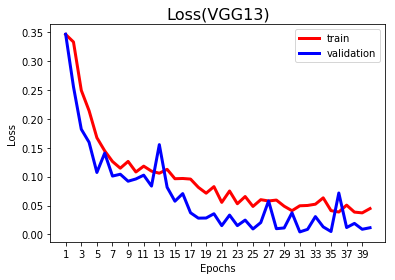

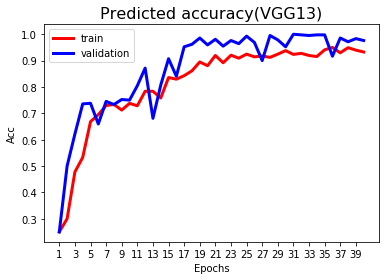

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss(VGG13)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy(VGG13)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:     81    77    75    75
Predicted:     81    77    75    75


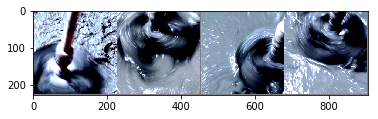

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('75', '77', '79', '81')

dataiter = iter(dataloders['validation'])
images, labels = dataiter.next()
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[z]] for z in range(4)))

# test
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[z]] for z in range(4)))

In [11]:
conc = {
    '0': '75  ',
    '1': '77  ',
    '2': '79  ',
    '3': '81  '
}

print("\t   Predicted\n")
print("\t   75\t77\t79\t81\n")
for i in range(0, num_classes):
    print("Actual ", end='')
    print(conc[str(i)], end='')
    for j in range(0, num_classes):
        print(str(best_matrix[i][j]) + '\t', end='')
    print('\n')

	   Predicted

	   75	77	79	81

Actual 75  105	0	0	0	

Actual 77  0	105	0	0	

Actual 79  0	0	105	0	

Actual 81  0	0	0	105	

